In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from scipy import stats


import warnings

pd.set_option('display.max_columns', None)
seed = 100
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
%matplotlib inline

# Utils

In [29]:
sns.set_style('darkgrid')

In [5]:
def show_features(dataframe):
    prefixes = []
    for col in dataframe.columns:
        parts = col.split('_')
    
        if parts[0] == "LBP":
            prefixes.append("LBP")
            
        elif parts[0] == "original":
            if len(parts) > 1:
                prefixes.append(parts[1])
            else:
                prefixes.append(parts[0])
        elif parts[0].startswith("wavelet"):
            prefixes.append('_'.join(parts[:2])) 
                
    column_counts = pd.Series(prefixes).value_counts()
    
    plt.bar(column_counts.index, column_counts.values)
    plt.xlabel('Type of features')
    plt.ylabel('Num. features')
    plt.title('Features distribution by type')
    plt.xticks(rotation=45)
    for index, value in enumerate(column_counts.values):
        plt.text(index, value, str(value), ha='center', va='bottom')
    plt.show()

In [14]:
def normalize_by_pixels(csv_path, roi_transforms):
    columns_to_remove = []
    
    features = pd.read_csv(csv_path)
    features_modified = features.copy()
    for column_name, function in roi_transforms.items():
        new_column_name = f"{column_name}_pix_norm"
        features_modified[new_column_name] = features.apply(
            lambda row: function(row['ROI pixels'], row[column_name]), axis=1)
        columns_to_remove.append(column_name)
    f = features_modified.drop(columns=columns_to_remove)
    new_file_name = csv_path.replace('.csv', '_norm.csv')
    f.to_csv(new_file_name, index=False)

In [9]:
def spearman_correlations(original, modified, transforms):
    correlations = {}    
    lower_correlation = {}
    
    for column_name in transforms.keys():
        original_corr = original[[column_name, 'ROI pixels']].corr(method='spearman').iloc[0, 1]
        modified_corr = modified[[f"{column_name}_pix_norm", 'ROI pixels']].corr(method='spearman').iloc[0, 1]
        correlations[column_name] = (original_corr, modified_corr)
    
    for column_name, (original_corr, modified_corr) in correlations.items():
        if original_corr < modified_corr:
            lower_correlation[column_name] = 'Original'
        else:
            lower_correlation[column_name] = 'Modified'
    
    return lower_correlation

# Robustness analysis

The number of pixels within the ROI might play a significant role in feature robustness.Resampling is not sufficient for some intensity histogram and texture features because the numerical values of these features are highly correlated with number of pixels in the ROI and this dependence can only be eliminated by including number of pixels in feature definitions (Hassan et al.). In the Hassan study with CT lung images these features were: histogram energy, GLRM-Grey level non-uniformity, GLRM-run-length non-uniformity (these were edited by dividing their values by the total number of pixels in the ROI in Fave et al. too), histogram-entropy, GLCM-mean, GLCM-inverse-variance.

Although we are working with ultrasonic images based on the mathematial definition of the features it is possible that the same will happen for this type of images. So we're going to study the area correlation for the features using the spearman rank correlation coefficient with the features where Hassen found dependences to see if there are some features extremely correlated with the number of pixels, regardless of the interpolation technique.  

## Anterior images

In [4]:
features_ant = pd.read_csv('../data/anterior/features_1.csv')
len(features_ant)

558

In [8]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.9, 0.1], 
                           n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, flip_y=0, random_state=42)

# Conteo de las clases antes del submuestreo
print("Distribución de clases original:", Counter(y))

# Inicialización del RandomUnderSampler con la estrategia 'all'
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Aplicación del submuestreo
X_res, y_res = rus.fit_resample(X, y)

# Conteo de las clases después del submuestreo
print("Distribución de clases después del submuestreo:", Counter(y_res))


Distribución de clases original: Counter({0: 900, 1: 100})
Distribución de clases después del submuestreo: Counter({0: 100, 1: 100})


In [12]:
roi_transforms = {
    'original_firstorder_Energy': lambda Np, feature: feature / Np,
    'original_firstorder_Entropy': lambda Np, feature: feature / np.log(Np),
    'LBP_R_1_P_8_Energy': lambda Np, feature: feature / Np,
    'LBP_R_1_P_8_Entropy': lambda Np, feature: feature / np.log(Np),
    'LBP_R_2_P_16_Energy': lambda Np, feature: feature / Np,
    'LBP_R_2_P_16_Entropy': lambda Np, feature: feature / np.log(Np),
    'LBP_R_3_P_24_Energy': lambda Np, feature: feature / Np,
    'LBP_R_3_P_24_Entropy': lambda Np, feature: feature / np.log(Np),
    'original_glcm_InverseVariance': lambda Np, feature: feature / Np,
    'original_glrlm_RunLengthNonUniformity': lambda Np, feature: feature / Np,
    'original_glrlm_GrayLevelNonUniformity': lambda Np, feature: feature / Np,
    'original_ngtdm_Strength': lambda Np, feature: feature / Np,
    'original_ngtdm_Coarseness': lambda Np, feature: feature / Np
}

In [6]:
features_ant_modified = features_ant.copy()
features_ant_modified

Record ID                 Image  Pixel spacing x  ROI pixels  Label  \
0            1  IMG_20220831_1_1.dcm         0.171585      110109      0   
1            1  IMG_20220831_1_2.dcm         0.171585       86173      0   
2            1  IMG_20220831_1_3.dcm         0.155005       72181      0   
3            2  IMG_20220908_2_1.dcm         0.185711       70648      0   
4            2  IMG_20220908_2_2.dcm         0.135971       74457      0   
..         ...                   ...              ...         ...    ...   
553        361  IMG_20230606_1_3.dcm         0.093003       34984      0   
554        361  IMG_20230606_1_4.dcm         0.093003       74469      0   
555        364  IMG_20230606_1_2.dcm         0.094083      110683      0   
556        364  IMG_20230606_1_3.dcm         0.094083       72922      0   
557        364  IMG_20230606_1_4.dcm         0.094083       80791      0   

     original_firstorder_Mean  original_firstorder_RootMeanSquared  \
0                   92.823802                            96.947011   
1                  120.620171                           122.642090   
2                   84.522284                            87.838445   
3                   70.886607                            76.576202   
4                   87.739272                            90.251697   
..                        ...                                  ...   
553                 93.565773                            95.113625   
554                118.126979                           120.058128   
555                111.502995                           112.926313   
556                 91.569581                            94.566868   
557                 99.222946                           101.212787   

     original_firstorder_StandardDeviation  original_firstorder_10Percentile  \
0                                27.972572                              60.0   
1                                22.177840                              93.0   
2                                23.907653                              52.0   
3                                28.965560                              34.0   
4                                21.146839                              61.0   
..                                     ...                               ...   
553                              17.089406                              72.0   
554                              21.446935                              91.0   
555                              17.872725                              89.0   
556                              23.620000                              62.0   
557                              19.970862                              74.0   

     original_firstorder_90Percentile  original_firstorder_Median  \
0                               131.0                        90.0   
1                               150.0                       120.0   
2                               114.0                        87.0   
3                               110.0                        69.0   
4                               115.0                        87.0   
..                                ...                         ...   
553                             116.0                        93.0   
554                             146.0                       118.0   
555                             135.0                       111.0   
556                             124.0                        90.0   
557                             125.0                        99.0   

     original_firstorder_Energy  original_firstorder_Entropy  \
0                  1.034884e+09                     5.821980   
1                  1.296135e+09                     5.508521   
2                  5.569192e+08                     5.599141   
3                  4.142738e+08                     5.876384   
4                  6.064797e+08                     5.441628   
..                          ...                          ...   
553          

In [7]:
for column_name, function in roi_transforms.items():
    new_column_name = f"{column_name}_pix_norm"
    features_ant_modified[new_column_name] = features_ant.apply(lambda row: function(row['ROI pixels'], row[column_name]), axis=1)

features_ant_modified

Record ID                 Image  Pixel spacing x  ROI pixels  Label  \
0            1  IMG_20220831_1_1.dcm         0.171585      110109      0   
1            1  IMG_20220831_1_2.dcm         0.171585       86173      0   
2            1  IMG_20220831_1_3.dcm         0.155005       72181      0   
3            2  IMG_20220908_2_1.dcm         0.185711       70648      0   
4            2  IMG_20220908_2_2.dcm         0.135971       74457      0   
..         ...                   ...              ...         ...    ...   
553        361  IMG_20230606_1_3.dcm         0.093003       34984      0   
554        361  IMG_20230606_1_4.dcm         0.093003       74469      0   
555        364  IMG_20230606_1_2.dcm         0.094083      110683      0   
556        364  IMG_20230606_1_3.dcm         0.094083       72922      0   
557        364  IMG_20230606_1_4.dcm         0.094083       80791      0   

     original_firstorder_Mean  original_firstorder_RootMeanSquared  \
0                   92.823802                            96.947011   
1                  120.620171                           122.642090   
2                   84.522284                            87.838445   
3                   70.886607                            76.576202   
4                   87.739272                            90.251697   
..                        ...                                  ...   
553                 93.565773                            95.113625   
554                118.126979                           120.058128   
555                111.502995                           112.926313   
556                 91.569581                            94.566868   
557                 99.222946                           101.212787   

     original_firstorder_StandardDeviation  original_firstorder_10Percentile  \
0                                27.972572                              60.0   
1                                22.177840                              93.0   
2                                23.907653                              52.0   
3                                28.965560                              34.0   
4                                21.146839                              61.0   
..                                     ...                               ...   
553                              17.089406                              72.0   
554                              21.446935                              91.0   
555                              17.872725                              89.0   
556                              23.620000                              62.0   
557                              19.970862                              74.0   

     original_firstorder_90Percentile  original_firstorder_Median  \
0                               131.0                        90.0   
1                               150.0                       120.0   
2                               114.0                        87.0   
3                               110.0                        69.0   
4                               115.0                        87.0   
..                                ...                         ...   
553                             116.0                        93.0   
554                             146.0                       118.0   
555                             135.0                       111.0   
556                             124.0                        90.0   
557                             125.0                        99.0   

     original_firstorder_Energy  original_firstorder_Entropy  \
0                  1.034884e+09                     5.821980   
1                  1.296135e+09                     5.508521   
2                  5.569192e+08                     5.599141   
3                  4.142738e+08                     5.876384   
4                  6.064797e+08                     5.441628   
..                          ...                          ...   
553          

In [10]:
lower_correlation = spearman_correlations(features_ant, features_ant_modified, roi_transforms)
lower_correlation

{'original_firstorder_Energy': 'Modified',
 'original_firstorder_Entropy': 'Modified',
 'LBP_R_1_P_8_Energy': 'Modified',
 'LBP_R_1_P_8_Entropy': 'Modified',
 'LBP_R_2_P_16_Energy': 'Modified',
 'LBP_R_2_P_16_Entropy': 'Modified',
 'LBP_R_3_P_24_Energy': 'Modified',
 'LBP_R_3_P_24_Entropy': 'Modified',
 'original_glcm_InverseVariance': 'Modified',
 'original_glrlm_RunLengthNonUniformity': 'Modified',
 'original_glrlm_GrayLevelNonUniformity': 'Modified',
 'original_ngtdm_Strength': 'Modified',
 'original_ngtdm_Coarseness': 'Modified'}

So we keep the modified features and remove the original features.

In [11]:
columns_to_remove = [f"{column_name}" for column_name, correlation_type in lower_correlation.items() if correlation_type == 'Modified']
features_ant_modified.drop(columns=columns_to_remove, inplace=True)
features_ant_modified

Record ID                 Image  Pixel spacing x  ROI pixels  Label  \
0            1  IMG_20220831_1_1.dcm         0.171585      110109      0   
1            1  IMG_20220831_1_2.dcm         0.171585       86173      0   
2            1  IMG_20220831_1_3.dcm         0.155005       72181      0   
3            2  IMG_20220908_2_1.dcm         0.185711       70648      0   
4            2  IMG_20220908_2_2.dcm         0.135971       74457      0   
..         ...                   ...              ...         ...    ...   
553        361  IMG_20230606_1_3.dcm         0.093003       34984      0   
554        361  IMG_20230606_1_4.dcm         0.093003       74469      0   
555        364  IMG_20230606_1_2.dcm         0.094083      110683      0   
556        364  IMG_20230606_1_3.dcm         0.094083       72922      0   
557        364  IMG_20230606_1_4.dcm         0.094083       80791      0   

     original_firstorder_Mean  original_firstorder_RootMeanSquared  \
0                   92.823802                            96.947011   
1                  120.620171                           122.642090   
2                   84.522284                            87.838445   
3                   70.886607                            76.576202   
4                   87.739272                            90.251697   
..                        ...                                  ...   
553                 93.565773                            95.113625   
554                118.126979                           120.058128   
555                111.502995                           112.926313   
556                 91.569581                            94.566868   
557                 99.222946                           101.212787   

     original_firstorder_StandardDeviation  original_firstorder_10Percentile  \
0                                27.972572                              60.0   
1                                22.177840                              93.0   
2                                23.907653                              52.0   
3                                28.965560                              34.0   
4                                21.146839                              61.0   
..                                     ...                               ...   
553                              17.089406                              72.0   
554                              21.446935                              91.0   
555                              17.872725                              89.0   
556                              23.620000                              62.0   
557                              19.970862                              74.0   

     original_firstorder_90Percentile  original_firstorder_Median  \
0                               131.0                        90.0   
1                               150.0                       120.0   
2                               114.0                        87.0   
3                               110.0                        69.0   
4                               115.0                        87.0   
..                                ...                         ...   
553                             116.0                        93.0   
554                             146.0                       118.0   
555                             135.0                       111.0   
556                             124.0                        90.0   
557                             125.0                        99.0   

     original_firstorder_Skewness  original_firstorder_Kurtosis  \
0                        0.317856                      2.803491   
1                        0.169213                      2.728930   
2                       -0.304509                      3.051693   
3                        0.338477                      2.875343   
4                        0.175028                      3.089692   
..                            ...                          

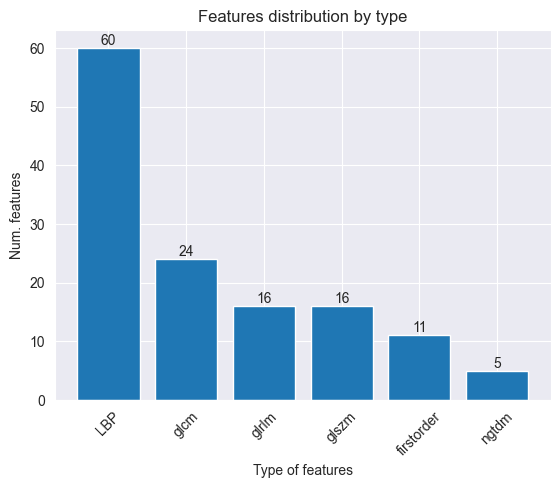

In [12]:
data = features_ant_modified.drop(['Label','Image','Record ID','Pixel spacing x','ROI pixels'], axis=1)
show_features(data)

In [ ]:
normalize_by_pixels('../data/anterior/features_1.csv', roi_transforms)

### My features

In [16]:
roi_transforms = {
    'GLH_Energy': lambda Np, feature: feature / Np,
    'GLH_Entropy': lambda Np, feature: feature / np.log(Np),
    'LBP_R_1_P_8_Energy': lambda Np, feature: feature / Np,
    'LBP_R_1_P_8_Entropy': lambda Np, feature: feature / np.log(Np),
    'LBP_R_2_P_16_Energy': lambda Np, feature: feature / Np,
    'LBP_R_2_P_16_Entropy': lambda Np, feature: feature / np.log(Np),
    'LBP_R_3_P_24_Energy': lambda Np, feature: feature / Np,
    'LBP_R_3_P_24_Entropy': lambda Np, feature: feature / np.log(Np),
    'GLRLM_RunLengthNonUniformity': lambda Np, feature: feature / Np,
    'GLRLM_GrayLevelNonUniformity': lambda Np, feature: feature / Np
}

In [4]:
features_ant_3sigma_7 = pd.read_csv('../data/anterior/my_df_3sigma_7.csv')
len(features_ant_3sigma_7)

538

In [207]:
features_ant_3sigma_7

Record ID                 Image  Pixel spacing x  Label  ROI pixels  \
0            1  IMG_20220831_1_3.dcm         0.155005      0       30043   
1            2  IMG_20220908_2_2.dcm         0.135971      0       40276   
2            2  IMG_20220908_2_3.dcm         0.102810      0       51032   
3           12  IMG_20220913_1_1.dcm         0.138425      0       25337   
4           12  IMG_20220913_1_2.dcm         0.138425      0       87348   
..         ...                   ...              ...    ...         ...   
533        361  IMG_20230606_1_3.dcm         0.093003      0       40443   
534        361  IMG_20230606_1_4.dcm         0.093003      0       86085   
535        364  IMG_20230606_1_2.dcm         0.094083      0      125050   
536        364  IMG_20230606_1_3.dcm         0.094083      0       82403   
537        364  IMG_20230606_1_4.dcm         0.094083      0       91348   

       GLH_Mean  GLH_Variance  GLH_Skewness  GLH_Kurtosis  GLH_Energy  \
0    127.956712  38263.737455     -0.504903     -2.742089    0.502265   
1    128.011818  38292.037542     -0.504543     -2.742741    0.468308   
2    127.845058  38194.246431     -0.504530     -2.742799    0.473444   
3    127.911217  38231.265493     -0.504408     -2.743001    0.487041   
4    127.892888  38219.274946     -0.504408     -2.742984    0.483454   
..          ...           ...           ...           ...         ...   
533  127.965989  38266.924327     -0.504649     -2.742563    0.503289   
534  127.983057  38277.615785     -0.504660     -2.742548    0.455748   
535  128.024054  38298.720061     -0.504652     -2.742521    0.482581   
536  128.033609  38306.808188     -0.504504     -2.742849    0.479874   
537  127.989633  38277.991987     -0.504541     -2.742737    0.460386   

     GLH_Entropy  GLH_10Percentile  GLH_25Percentile  GLH_50Percentile  \
0      13.504182              17.0              25.0              32.0   
1      13.668106              18.0              24.0              31.0   
2      13.567730              18.0              24.0              31.0   
3      13.511562              18.0              24.0              31.0   
4      13.536489              19.0              24.0              31.0   
..           ...               ...               ...               ...   
533    13.435676              18.0              24.0              31.0   
534    13.762886              18.0              24.0              31.0   
535    13.507820              19.0              25.0              31.0   
536    13.531646              18.0              24.0              31.0   
537    13.678052              18.0              24.0              31.0   

     GLH_75Percentile  GLH_90Percentile  GLCM_Angular_Second_Moment_d1  \
0                39.0              44.0                       0.002666   
1                38.0              45.0                       0.002416   
2                39.0              45.0                       0.002919   
3                38.0              46.0                       0.002300   
4                38.0              45.0                       0.002539   
..                ...               ...                            ...   
533              39.0              45.0                       0.002952   
534              38.0              45.0                       0.002791   
535              38.0              45.0                       0.002737   
536              39.0              46.0                       0.003634   
537              38.0              45.0                       0.002634   

     GLCM_Contrast_d1  GLCM_Correlation_d1  GLCM_Sum_of_Squares_d1  \
0           20.158475             0.908726              110.441091   
1           18.308280             0.915947              109.007070   
2           13.966406             0.936159              109.444283   
3           25.952490             0.880912              109.017719   
4           22.746076             0.895626              108.944835   
..               

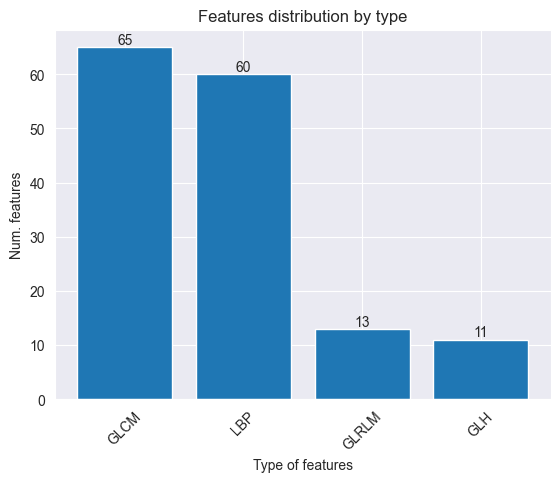

In [208]:
data = features_ant_3sigma_7.drop(['Label','Image','Record ID','Pixel spacing x', 'ROI pixels'], axis=1)
show_features(data)

In [45]:
features_ant_3sigma_7_modified = features_ant_3sigma_7.copy()
features_ant_3sigma_7_modified
for column_name, function in roi_transforms.items():
    new_column_name = f"{column_name}_pix_norm"
    features_ant_3sigma_7_modified[new_column_name] = features_ant_3sigma_7.apply(lambda row: function(row['ROI pixels'], row[column_name]), axis=1)

features_ant_3sigma_7_modified

Record ID                 Image  Pixel spacing x  Label  ROI pixels  \
0            1  IMG_20220831_1_3.dcm         0.155005      0       30043   
1            2  IMG_20220908_2_2.dcm         0.135971      0       40276   
2            2  IMG_20220908_2_3.dcm         0.102810      0       51032   
3           12  IMG_20220913_1_1.dcm         0.138425      0       25337   
4           12  IMG_20220913_1_2.dcm         0.138425      0       87348   
..         ...                   ...              ...    ...         ...   
533        361  IMG_20230606_1_3.dcm         0.093003      0       40443   
534        361  IMG_20230606_1_4.dcm         0.093003      0       86085   
535        364  IMG_20230606_1_2.dcm         0.094083      0      125050   
536        364  IMG_20230606_1_3.dcm         0.094083      0       82403   
537        364  IMG_20230606_1_4.dcm         0.094083      0       91348   

       GLH_Mean  GLH_Variance  GLH_Skewness  GLH_Kurtosis  GLH_Energy  \
0    127.956712  38263.737455     -0.504903     -2.742089    0.502265   
1    128.011818  38292.037542     -0.504543     -2.742741    0.468308   
2    127.845058  38194.246431     -0.504530     -2.742799    0.473444   
3    127.911217  38231.265493     -0.504408     -2.743001    0.487041   
4    127.892888  38219.274946     -0.504408     -2.742984    0.483454   
..          ...           ...           ...           ...         ...   
533  127.965989  38266.924327     -0.504649     -2.742563    0.503289   
534  127.983057  38277.615785     -0.504660     -2.742548    0.455748   
535  128.024054  38298.720061     -0.504652     -2.742521    0.482581   
536  128.033609  38306.808188     -0.504504     -2.742849    0.479874   
537  127.989633  38277.991987     -0.504541     -2.742737    0.460386   

     GLH_Entropy  GLH_10Percentile  GLH_25Percentile  GLH_50Percentile  \
0      13.504182              17.0              25.0              32.0   
1      13.668106              18.0              24.0              31.0   
2      13.567730              18.0              24.0              31.0   
3      13.511562              18.0              24.0              31.0   
4      13.536489              19.0              24.0              31.0   
..           ...               ...               ...               ...   
533    13.435676              18.0              24.0              31.0   
534    13.762886              18.0              24.0              31.0   
535    13.507820              19.0              25.0              31.0   
536    13.531646              18.0              24.0              31.0   
537    13.678052              18.0              24.0              31.0   

     GLH_75Percentile  GLH_90Percentile  GLCM_Angular_Second_Moment_d1  \
0                39.0              44.0                       0.002666   
1                38.0              45.0                       0.002416   
2                39.0              45.0                       0.002919   
3                38.0              46.0                       0.002300   
4                38.0              45.0                       0.002539   
..                ...               ...                            ...   
533              39.0              45.0                       0.002952   
534              38.0              45.0                       0.002791   
535              38.0              45.0                       0.002737   
536              39.0              46.0                       0.003634   
537              38.0              45.0                       0.002634   

     GLCM_Contrast_d1  GLCM_Correlation_d1  GLCM_Sum_of_Squares_d1  \
0           20.158475             0.908726              110.441091   
1           18.308280             0.915947              109.007070   
2           13.966406             0.936159              109.444283   
3           25.952490             0.880912              109.017719   
4           22.746076             0.895626              108.944835   
..               

In [46]:
lower_correlation = spearman_correlations(features_ant_3sigma_7, features_ant_3sigma_7_modified)
lower_correlation

{'GLH_Energy': 'Modified',
 'GLH_Entropy': 'Modified',
 'LBP_R_1_P_8_Energy': 'Modified',
 'LBP_R_1_P_8_Entropy': 'Modified',
 'LBP_R_2_P_16_Energy': 'Modified',
 'LBP_R_2_P_16_Entropy': 'Modified',
 'LBP_R_3_P_24_Energy': 'Modified',
 'LBP_R_3_P_24_Entropy': 'Modified',
 'GLRLM_RunLengthNonUniformity': 'Modified',
 'GLRLM_GrayLevelNonUniformity': 'Modified'}

In [79]:
normalize_by_pixels('../data/anterior/my_df_3sigma_6_resegment.csv', roi_transforms)

In [46]:
normalize_by_pixels('../data/anterior/my_df_3sigma_7_int_fgr.csv', roi_transforms)

In [57]:
normalize_by_pixels('../data/anterior/my_df_3sigma_7_int_pe.csv', roi_transforms)

In [ ]:
normalize_by_pixels('../data/anterior/my_df_3sigma_7_pe.csv', roi_transforms)

In [ ]:
normalize_by_pixels('../data/anterior/my_df_3sigma_7_fgr.csv', roi_transforms)

In [73]:
normalize_by_pixels('../data/anterior/my_df_3sigma_7_pe.csv', roi_transforms)

In [87]:
normalize_by_pixels('../data/anterior/my_df_3sigma_7_fgr.csv', roi_transforms)

In [90]:
normalize_by_pixels('../data/anterior/my_df_3sigma_raw.csv', roi_transforms)

In [161]:
normalize_by_pixels('../data/anterior/my_df_3sigma_8_fgr.csv', roi_transforms)

In [100]:
normalize_by_pixels('../data/anterior/my_df_3sigma_fgr_raw.csv', roi_transforms)

In [101]:
normalize_by_pixels('../data/anterior/my_df_3sigma_pe_raw.csv', roi_transforms)

In [46]:
lbp_transforms = {
  
    'LBP_R_1_P_8_Energy': lambda Np, feature: feature / Np,
    'LBP_R_1_P_8_Entropy': lambda Np, feature: feature / np.log(Np),
    'LBP_R_2_P_16_Energy': lambda Np, feature: feature / Np,
    'LBP_R_2_P_16_Entropy': lambda Np, feature: feature / np.log(Np),
    'LBP_R_3_P_24_Energy': lambda Np, feature: feature / Np,
    'LBP_R_3_P_24_Entropy': lambda Np, feature: feature / np.log(Np),
   
}

In [28]:
lbp_features = pd.read_csv('../data/anterior/lbp.csv')

In [31]:
lbp_features_modified = lbp_features.copy()

for column_name, function in lbp_transforms.items():
    new_column_name = f"{column_name}_pix_norm"
    lbp_features_modified[new_column_name] = lbp_features.apply(lambda row: function(row['ROI pixels'], row[column_name]), axis=1)

lbp_features_modified

Record ID                 Image  Pixel spacing x  Label  ROI pixels  \
0            1  IMG_20220831_1_3.dcm         0.155005      0       30043   
1            2  IMG_20220908_2_2.dcm         0.135971      0       40276   
2            2  IMG_20220908_2_3.dcm         0.102810      0       51032   
3           12  IMG_20220913_1_1.dcm         0.138425      0       25337   
4           12  IMG_20220913_1_2.dcm         0.138425      0       87348   
..         ...                   ...              ...    ...         ...   
533        361  IMG_20230606_1_3.dcm         0.093003      0       40443   
534        361  IMG_20230606_1_4.dcm         0.093003      0       86085   
535        364  IMG_20230606_1_2.dcm         0.094083      0      125050   
536        364  IMG_20230606_1_3.dcm         0.094083      0       82403   
537        364  IMG_20230606_1_4.dcm         0.094083      0       91348   

     LBP_R_1_P_8_Energy  LBP_R_1_P_8_Entropy  LBP_R_1_P_8_Hist_1  \
0              0.174248             2.930290            0.023256   
1              0.175768             2.893800            0.016147   
2              0.220534             2.682853            0.009380   
3              0.182886             2.889093            0.020974   
4              0.195008             2.830151            0.015225   
..                  ...                  ...                 ...   
533            0.249397             2.574029            0.005588   
534            0.249157             2.557881            0.006425   
535            0.258445             2.528169            0.005339   
536            0.252141             2.563335            0.006011   
537            0.250202             2.567118            0.007081   

     LBP_R_1_P_8_Hist_2  LBP_R_1_P_8_Hist_3  LBP_R_1_P_8_Hist_4  \
0              0.086329            0.052170            0.101477   
1              0.069362            0.055192            0.134540   
2              0.054933            0.045673            0.135007   
3              0.075746            0.059198            0.120341   
4              0.083482            0.046016            0.096903   
..                  ...                 ...                 ...   
533            0.055375            0.037950            0.106559   
534            0.048504            0.038242            0.122494   
535            0.050848            0.034716            0.110869   
536            0.053773            0.035778            0.108302   
537            0.050117            0.039054            0.117641   

     LBP_R_1_P_8_Hist_5  LBP_R_1_P_8_Hist_6  LBP_R_1_P_8_Hist_7  \
0              0.346629            0.115831            0.064178   
1              0.338005            0.137954            0.074060   
2              0.406248            0.144085            0.066849   
3              0.360195            0.109999            0.059943   
4              0.379404            0.123068            0.061991   
..                  ...                 ...                 ...   
533            0.448791            0.147353            0.057534   
534            0.443979            0.154181            0.062292   
535            0.457819            0.152854            0.058525   
536            0.452132            0.146832            0.058160   
537            0.448172            0.147907            0.059272   

     LBP_R_1_P_8_Hist_8  LBP_R_1_P_8_Hist_9  LBP_R_1_P_8_Hist_10  \
0              0.091574            0.051066             0.067490   
1              0.077423            0.043383             0.053934   
2              0.064353            0.034703             0.038769   
3              0.086832            0.048442             0.058330   
4              0.087780            0.049435             0.056697   
..                  ...                 ...                  ...   
533            0.064342            0.039042             0.037467   
534            0.057838            0.032375             0.033670   
535            0.059269            0.035297          

In [35]:
lower_correlation = spearman_correlations(lbp_features, lbp_features_modified, lbp_transforms)
lower_correlation

{'LBP_R_1_P_8_Energy': 'Modified',
 'LBP_R_1_P_8_Entropy': 'Modified',
 'LBP_R_2_P_16_Energy': 'Modified',
 'LBP_R_2_P_16_Entropy': 'Modified',
 'LBP_R_3_P_24_Energy': 'Modified',
 'LBP_R_3_P_24_Entropy': 'Modified'}

In [82]:
normalize_by_pixels('../data/anterior/lbp.csv', lbp_transforms)

In [94]:
normalize_by_pixels('../data/anterior/lbp_pe.csv', lbp_transforms)

In [91]:
normalize_by_pixels('../data/anterior/lbp_fgr.csv', lbp_transforms)

In [47]:
normalize_by_pixels('../data/anterior/lbp_val_fgr.csv', lbp_transforms)

## Posterior images

In [31]:
features_post = pd.read_csv('../data/posterior/features_1.csv')
len(features_post)

521

In [ ]:
features_post_modified = features_post.copy()
features_post_modified

In [111]:
for column_name, function in roi_transforms.items():
    new_column_name = f"{column_name}_pix_norm"
    features_post_modified[new_column_name] = features_post.apply(lambda row: function(row['ROI pixels'], row[column_name]), axis=1)

features_post_modified

Record ID                 Image  Pixel spacing x  ROI pixels  Label  \
0            4  IMG_20220906_2_1.dcm         0.259534      150984      0   
1            4  IMG_20220906_2_2.dcm         0.259534      206177      0   
2            4  IMG_20220906_2_3.dcm         0.259534      107001      0   
3            5  IMG_20220906_2_1.dcm         0.190325      143484      0   
4            5  IMG_20220906_2_2.dcm         0.190325      193642      0   
..         ...                   ...              ...         ...    ...   
516        363  IMG_20230606_1_3.dcm         0.132760       38602      0   
517        363  IMG_20230606_1_4.dcm         0.148219       49338      0   
518        366  IMG_20230608_1_1.dcm         0.112165       45931      0   
519        366  IMG_20230608_1_2.dcm         0.112165       37992      0   
520        366  IMG_20230608_1_3.dcm         0.112165       39243      0   

     original_firstorder_Mean  original_firstorder_RootMeanSquared  \
0                  144.911414                           147.631699   
1                  201.601604                           202.040852   
2                  111.976617                           112.807099   
3                  144.674709                           146.534496   
4                  138.663136                           139.320940   
..                        ...                                  ...   
516                130.578934                           132.887976   
517                106.233958                           107.433399   
518                102.584485                           104.275779   
519                146.233418                           149.066571   
520                121.044186                           122.621902   

     original_firstorder_StandardDeviation  original_firstorder_10Percentile  \
0                                28.209935                             110.0   
1                                13.315359                             184.0   
2                                13.663050                              95.0   
3                                23.272024                             113.0   
4                                13.522533                             122.0   
..                                     ...                               ...   
516                              24.664880                              99.0   
517                              16.008792                              87.0   
518                              18.704585                              78.0   
519                              28.924558                             115.0   
520                              19.607033                              97.0   

     original_firstorder_90Percentile  original_firstorder_Median  \
0                               184.0                       142.0   
1                               218.0                       203.0   
2                               129.0                       112.0   
3                               176.0                       145.0   
4                               156.0                       139.0   
..                                ...                         ...   
516                             163.0                       130.0   
517                             126.0                       106.0   
518                             127.0                       102.0   
519                             193.0                       139.0   
520                             147.0                       120.0   

     original_firstorder_Energy  original_firstorder_Entropy  \
0                  3.290714e+09                     5.813428   
1                  8.416249e+09                     4.765883   
2                  1.361635e+09                     4.810356   
3                  3.080940e+09                     5.537335   
4                  3.758654e+09                     4.799928   
..                          ...                          ...   
516          

In [112]:
lower_correlation = spearman_correlations(features_post, features_post_modified)
lower_correlation

{'original_firstorder_Energy': 'Modified',
 'original_firstorder_Entropy': 'Modified',
 'LBP_R_1_P_8_Energy': 'Modified',
 'LBP_R_1_P_8_Entropy': 'Modified',
 'LBP_R_2_P_16_Energy': 'Modified',
 'LBP_R_2_P_16_Entropy': 'Modified',
 'LBP_R_3_P_24_Energy': 'Modified',
 'LBP_R_3_P_24_Entropy': 'Modified',
 'original_glcm_InverseVariance': 'Modified',
 'original_glrlm_RunLengthNonUniformity': 'Modified',
 'original_glrlm_GrayLevelNonUniformity': 'Modified',
 'original_ngtdm_Strength': 'Modified',
 'original_ngtdm_Coarseness': 'Modified'}

In [98]:
normalize_by_pixels('../data/all/my_df_3sigma_7_norm.csv', roi_transforms)

## All

In [119]:
normalize_by_pixels('../data/all/my_df_3sigma_7_fgr_c_all.csv', roi_transforms)

In [122]:
normalize_by_pixels('../data/all/lbp_fgr.csv', lbp_transforms)

In [137]:
normalize_by_pixels('../data/all/my_df_3sigma_7_fgr_all.csv', roi_transforms)

In [142]:
normalize_by_pixels('../data/all/my_df_3sigma_raw_fgr.csv', roi_transforms)

## Dummy dataset

In [176]:
normalize_by_pixels('../data/dummy/sand_stone_mask.csv', roi_transforms)
normalize_by_pixels('../data/dummy/sand_stone_mask_3sigma.csv', roi_transforms)

In [177]:
normalize_by_pixels('../data/dummy/blanket_stone_mask.csv', roi_transforms)
normalize_by_pixels('../data/dummy/blanket_stone_mask_3sigma.csv', roi_transforms)

In [18]:
normalize_by_pixels('../data/dummy/blanket_stone_mask_val_3sigma.csv', roi_transforms)

# Stadistical tests
To study the difference between means we'll apply t-test if we have normality and homocedasticity, Welch’s t-test if we have normality but heterocedasticity. If not we will use Mann-Whitney U

## Normality/Homocedasticity

In [3]:
def levene_eq_var_test(data1, data2, alpha = 0.05):
     """
    Computes the Levene test of equal variance
    :param data1: dataframe with class 1 samples
    :param data2: dataframe with class 2 samples
    :return: list of columns that presents homocedasticity
    """
     homocedasticity = []
     
     for feature in data1.columns:   
         _, p_value = levene(data1[feature], data2[feature])
         # If p-value > alpha we cannot reject the null hyphotesis of homocedasticity
         if p_value > alpha: 
           homocedasticity.append(feature)
             
     return homocedasticity

In [4]:
def shapiro_test(data, alpha=0.05):
    """
    Computes the Shapiro test for normality in the dataframe columns
    :param data: dataframe
    :return:  list of columns that presents normality
    """
     
    normality = []
    for feature in data.columns:
        _, p_value = stats.shapiro(data[feature])
        # If p-value > alpha we accept the null hyphotesis of normality
        if p_value > alpha:
            normality.append(feature)
     
    return normality

In [5]:
def get_data(input_csv, offset=5, LBP=True):
    features = pd.read_csv(input_csv)
    if LBP!=True:
        columns_to_drop = [col for col in features.columns if col.startswith('LBP')]
        features = features.drop(columns=columns_to_drop)
   
    healthy = features[features['Label'] == 0]
    insufficiency = features[features['Label'] == 1]
    features_healthy = healthy.iloc[:, offset:].copy()
    features_insufficiency = insufficiency.iloc[:, offset:].copy()
    levene_results = levene_eq_var_test(features_healthy, 
                                        features_insufficiency)
    healthy_shapiro_results = shapiro_test(features_healthy)
    insufficiency_shapiro_results = shapiro_test(features_insufficiency)
    
    return features_healthy, features_insufficiency, levene_results, healthy_shapiro_results, insufficiency_shapiro_results

## Sand stone blanket

In [29]:
sand_stone = pd.read_csv('../data/dummy/sand_stone.csv')
sand_stone_healthy, sand_stone_ins, sand_stone_levene_results, healthy_shapiro_sand_stone,insufficiency_shapiro_results_sand_stone = get_data('../data/sand_stone.csv', 3)

In [35]:
sand_stone_3sigma = pd.read_csv('../data/dummy/sand_stone_3sigma.csv')
sand_stone_healthy_3sigma, sand_stone_ins_3sigma, sand_stone_levene_results_3sigma, healthy_shapiro_sand_stone_3sigma,insufficiency_shapiro_results_sand_stone_3sigma = get_data('../data/dummy/sand_stone_3sigma.csv', 3)

In [39]:
blanket_stone = pd.read_csv('../data/dummy/blanket_stone.csv')
blanket_stone_healthy, blanket_stone_ins, blanket_stone_levene_results, healthy_shapiro_blanket_stone,insufficiency_shapiro_results_blanket_stone = get_data('../data/dummy/blanket_stone.csv', 3)

In [175]:
blanket_stone_3sigma = pd.read_csv('../data/dummy/blanket_stone_3sigma.csv')
blanket_stone_healthy_3sigma, blanket_stone_ins_3sigma, blanket_stone_levene_results_3sigma, healthy_shapiro_blanket_stone_3sigma,insufficiency_shapiro_results_blanket_stone_3sigma = get_data('../data/dummy/blanket_stone_3sigma.csv', 3)

In [46]:
sand_stone_mask_norm = pd.read_csv('../data/dummy/sand_stone_mask_norm.csv')
sand_stone_mask_norm_healthy, sand_stone_mask_norm_ins, sand_stone_mask_norm_levene_results, healthy_shapiro_sand_stone_mask_norm,insufficiency_shapiro_results_sand_stone_mask_norm = get_data('../data/dummy/sand_stone_mask_norm.csv', 4)

In [47]:
sand_stone_mask_3sigma_norm = pd.read_csv('../data/dummy/sand_stone_mask_3sigma_norm.csv')
sand_stone_mask_3sigma_norm_healthy, sand_stone_mask_3sigma_norm_ins, sand_stone_mask_3sigma_norm_levene_results, healthy_shapiro_sand_stone_mask_3sigma_norm,insufficiency_shapiro_results_sand_stone_mask_3sigma_norm = get_data('../data/dummy/sand_stone_mask_3sigma_norm.csv', 4)

In [38]:
blanket_stone_mask_norm = pd.read_csv('../data/dummy/blanket_stone_mask_norm.csv')
blanket_stone_mask_norm_healthy, blanket_stone_mask_norm_ins, blanket_stone_mask_norm_levene_results, healthy_shapiro_blanket_stone_mask_norm,insufficiency_shapiro_results_blanket_stone_mask_norm = get_data('../data/dummy/blanket_stone_mask_norm.csv', 4)

In [40]:
blanket_stone_3sigma_mask_norm = pd.read_csv('../data/dummy/blanket_stone_mask_3sigma_norm.csv')
blanket_stone_healthy_3sigma_mask_norm, blanket_stone_ins_3sigma_mask_norm, blanket_stone_levene_results_3sigma_mask_norm, healthy_shapiro_blanket_stone_3sigma_mask_norm,insufficiency_shapiro_results_blanket_stone_3sigma_mask_norm = get_data('../data/dummy/blanket_stone_mask_3sigma_norm.csv', 4)

In [19]:
blanket_stone_3sigma_mask_norm_not_balanced = pd.read_csv('../data/dummy/blanket_stone_mask_3sigma_norm_not_balanced.csv')
blanket_stone_healthy_3sigma_mask_norm_not_balanced, blanket_stone_ins_3sigma_mask_norm_not_balanced, blanket_stone_levene_results_3sigma_mask_norm_not_balanced, healthy_shapiro_blanket_stone_3sigma_mask_norm_not_balanced,insufficiency_shapiro_results_blanket_stone_3sigma_mask_norm_not_balanced = get_data('../data/dummy/blanket_stone_mask_3sigma_norm_not_balanced.csv', 4)

## Balanced data

In [12]:
my_df_3sigma_7_fgr_norm_eq = pd.read_csv('../data/anterior/my_df_3sigma_7_fgr_norm_eq.csv')
my_df_3sigma_7_fgr_eq_healthy_norm, my_df_3sigma_7_fgr_eq_ins_norm, levene_my_df_3sigma_7_fgr_eq_results_norm, healthy_shapiro_my_df_3sigma_7_fgr_eq_results_norm, insufficiency_shapiro_my_df_3sigma_7_fgr_eq_norm = get_data('../data/anterior/my_df_3sigma_7_fgr_norm_eq.csv')

In [13]:
my_df_3sigma_7_pe_norm_eq = pd.read_csv('../data/anterior/my_df_3sigma_7_pe_norm_eq.csv')
my_df_3sigma_7_pe_eq_healthy_norm, my_df_3sigma_7_pe_eq_ins_norm, levene_my_df_3sigma_7_fgr_eq_results_norm, healthy_shapiro_my_df_3sigma_7_pe_eq_norm,insufficiency_shapiro_my_df_3sigma_7_pe_eq_norm = get_data('../data/anterior/my_df_3sigma_7_pe_norm_eq.csv')

In [14]:
my_df_3sigma_raw_pe_eq_norm = pd.read_csv('../data/anterior/my_df_3sigma_pe_raw_norm_eq.csv')
my_df_3sigma_raw_pe_eq_healthy_norm, my_df_3sigma_raw_pe_eq_ins_norm, levene_my_df_3sigma_raw_pe_eq_norm, healthy_shapiro_my_df_3sigma_raw_pe_eq_norm,insufficiency_shapiro_my_df_3sigma_raw_pe_eq_norm = get_data('../data/anterior/my_df_3sigma_pe_raw_norm_eq.csv')

In [76]:
my_df_3sigma_raw_fgr_eq_norm = pd.read_csv('../data/anterior/my_df_3sigma_raw_fgr_eq_norm.csv')
my_df_3sigma_raw_fgr_eq_healthy_norm, my_df_3sigma_raw_fgr_eq_ins_norm, levene_my_df_3sigma_raw_fgr_eq_norm, healthy_shapiro_my_df_3sigma_raw_fgr_eq_norm,insufficiency_shapiro_my_df_3sigma_raw_fgr_eq_norm = get_data('../data/anterior/my_df_3sigma_raw_fgr_eq_norm.csv')

In [58]:
features_3_pe_pix_norm_eq = pd.read_csv('../data/anterior/features_3_pe_pix_norm_eq.csv')
features_3_pe_pix_eq_healthy_norm, features_3_pe_pix_eq_ins_norm, levene_features_3_pe_pix_eq_norm, healthy_shapiro_features_3_pe_pix_eq_norm,insufficiency_features_3_pe_pix_eq_norm = get_data('../data/anterior/features_3_pe_pix_norm_eq.csv')

In [60]:
features_3_fgr_pix_norm_eq = pd.read_csv('../data/anterior/features_3_fgr_pix_norm_eq.csv')
features_3_fgr_pix_eq_healthy_norm, features_3_fgr_pix_eq_ins_norm, levene_features_3_fgr_pix_eq_norm, healthy_shapiro_features_3_fgr_pix_eq_norm,insufficiency_shapiro_features_3_fgr_pix_eq_norm = get_data('../data/anterior/features_3_fgr_pix_norm_eq.csv')

In [79]:
features_3_fgr_pix_norm_eq_lbp = pd.read_csv('../data/anterior/features_3_fgr_pix_norm_eq_lbp.csv')
features_3_fgr_pix_eq_healthy_norm_lbp, features_3_fgr_pix_eq_ins_norm_lbp, levene_features_3_fgr_pix_eq_norm_lbp, healthy_shapiro_features_3_fgr_pix_eq_norm_lbp,insufficiency_shapiro_features_3_fgr_pix_eq_norm_lbp = get_data('../data/anterior/features_3_fgr_pix_norm_eq.csv')

In [11]:
features_5_fgr_pix_norm_eq = pd.read_csv('../data/anterior/features_5_fgr_pix_norm_eq.csv')
features_5_fgr_pix_eq_healthy_norm, features_5_fgr_pix_eq_ins_norm, levene_features_5_fgr_pix_eq_norm, healthy_shapiro_features_5_fgr_pix_eq_norm,insufficiency_shapiro_features_5_fgr_pix_eq_norm = get_data('../data/anterior/features_5_fgr_pix_norm_eq.csv')

In [12]:
features_5_pe_pix_norm_eq = pd.read_csv('../data/anterior/features_5_pe_pix_norm_eq.csv')
features_5_pe_pix_eq_healthy_norm, features_3_pe_pix_eq_ins_norm, levene_features_5_pe_pix_eq_norm, healthy_shapiro_features_5_pe_pix_eq_norm,insufficiency_features_5_pe_pix_eq_norm = get_data('../data/anterior/features_5_pe_pix_norm_eq.csv')

In [13]:
features_5_fgr_pix_norm_eq_lbp = pd.read_csv('../data/anterior/features_5_fgr_pix_norm_eq_lbp.csv')
features_5_fgr_pix_eq_healthy_norm_lbp, features_5_fgr_pix_eq_ins_norm_lbp, levene_features_5_fgr_pix_eq_norm_lbp, healthy_shapiro_features_5_fgr_pix_eq_norm_lbp,insufficiency_shapiro_features_5_fgr_pix_eq_norm_lbp = get_data('../data/anterior/features_5_fgr_pix_norm_eq_lbp.csv')

In [26]:
features_5_pe_pix_norm_eq_lbp = pd.read_csv('../data/anterior/features_5_pe_pix_norm_eq_lbp.csv')
features_5_pe_pix_eq_healthy_norm_lbp, features_3_pe_pix_eq_ins_norm_lbp, levene_features_5_pe_pix_eq_norm_lbp, healthy_shapiro_features_5_pe_pix_eq_norm_lbp,insufficiency_features_5_pe_pix_eq_norm_lbp = get_data('../data/anterior/features_5_pe_pix_norm_eq_lbp.csv')

## Anterior images

In [46]:
features_ant_norm = pd.read_csv('../data/anterior/features_1_pix_norm.csv')
features_healthy_ant_norm, features_insufficiency_ant_norm, levene_results_ant_norm, healthy_shapiro_results_ant_norm,insufficiency_shapiro_results_ant_norm = get_data('../data/anterior/features_1_pix_norm.csv')

In [6]:
features_ant_norm_no_lbp = pd.read_csv('../data/anterior/features_1_pix_norm.csv')
features_healthy_ant_norm_no_lbp, features_insufficiency_ant_norm_no_lbp, levene_results_ant_norm_no_lbp, healthy_shapiro_results_ant_norm_no_lbp,insufficiency_shapiro_results_ant_norm_no_lbp = get_data('../data/anterior/features_1_pix_norm.csv', LBP=False)

In [49]:
features_ant_norm2 = pd.read_csv('../data/anterior/features_2_pix_norm.csv')
features_healthy_ant_norm2, features_insufficiency_ant_norm2, levene_results_ant_norm2, healthy_shapiro_results_ant_norm2,insufficiency_shapiro_results_ant_norm2 = get_data('../data/anterior/features_2_pix_norm.csv')

In [11]:
features_ant_norm2_no_lbp = pd.read_csv('../data/anterior/features_2_pix_norm.csv')
features_healthy_ant_norm2_no_lbp, features_insufficiency_ant_norm2_no_lbp, levene_results_ant_norm2_no_lbp, healthy_shapiro_results_ant_norm2_no_lbp,insufficiency_shapiro_results_ant_norm2_no_lbp = get_data('../data/anterior/features_2_pix_norm.csv', LBP=False)

In [51]:
features_ant_norm3 = pd.read_csv('../data/anterior/features_3_pix_norm.csv')
features_healthy_ant_norm3, features_insufficiency_ant_norm3, levene_results_ant_norm3, healthy_shapiro_results_ant_norm3,insufficiency_shapiro_results_ant_norm3 = get_data('../data/anterior/features_3_pix_norm.csv')

In [13]:
features_ant_norm3_no_lbp = pd.read_csv('../data/anterior/features_3_pix_norm.csv')
features_healthy_ant_norm3_no_lbp, features_insufficiency_ant_norm3_no_lbp, levene_results_ant_norm3_no_lbp, healthy_shapiro_results_ant_norm3_no_lbp,insufficiency_shapiro_results_ant_norm3_no_lbp = get_data('../data/anterior/features_3_pix_norm.csv', LBP=False)

In [159]:
features_ant_zscore_fgr_norm3 = pd.read_csv('../data/anterior/features_3_zscore_fgr_pix_norm.csv')
features_healthy_ant_zscore_fgr_norm3, features_insufficiency_ant_zscore_fgr_norm3, levene_results_ant_zscore_fgr_norm3, healthy_shapiro_results_ant_zscore_fgr_norm3,insufficiency_shapiro_results_ant_zscore_fgr_norm3 = get_data('../data/anterior/features_3_zscore_fgr_pix_norm.csv')

In [53]:
features_ant_norm4 = pd.read_csv('../data/anterior/features_4_pix_norm.csv')
features_healthy_ant_norm4, features_insufficiency_ant_norm4, levene_results_ant_norm4, healthy_shapiro_results_ant_norm4,insufficiency_shapiro_results_ant_norm4 = get_data('../data/anterior/features_4_pix_norm.csv')

In [15]:
features_ant_norm4_no_lbp = pd.read_csv('../data/anterior/features_4_pix_norm.csv')
features_healthy_ant_norm4_no_lbp, features_insufficiency_ant_norm4_no_lbp, levene_results_ant_norm4_no_lbp, healthy_shapiro_results_ant_norm4_no_lbp,insufficiency_shapiro_results_ant_norm4_no_lbp = get_data('../data/anterior/features_4_pix_norm.csv', LBP=False)

In [40]:
features_ant_norm5 = pd.read_csv('../data/anterior/features_5_pix_norm.csv')
features_healthy_ant_norm5, features_insufficiency_ant_norm5, levene_results_ant_norm5, healthy_shapiro_results_ant_norm5,insufficiency_shapiro_results_ant_norm5 = get_data('../data/anterior/features_5_pix_norm.csv')

In [24]:
features_ant_lbp_norm5 = pd.read_csv('../data/anterior/features_5_lbp_pix_norm.csv')
features_healthy_ant_lbp_norm5, features_insufficiency_ant_lbp_norm5, levene_results_ant_lbp_norm5, healthy_shapiro_results_ant_lbp_norm5,insufficiency_shapiro_results_ant_lbp_norm5 = get_data('../data/anterior/features_5_lbp_pix_norm.csv')

In [62]:
features_ant_norm6 = pd.read_csv('../data/anterior/features_6_pix_norm.csv')
features_healthy_ant_norm6, features_insufficiency_ant_norm6, levene_results_ant_norm6, healthy_shapiro_results_ant_norm6,insufficiency_shapiro_results_ant_norm6 = get_data('../data/anterior/features_6_pix_norm.csv')

In [17]:
features_ant_norm6_no_lbp = pd.read_csv('../data/anterior/features_6_pix_norm.csv')
features_healthy_ant_norm6_no_lbp, features_insufficiency_ant_norm6_no_lbp, levene_results_ant_norm6_no_lbp, healthy_shapiro_results_ant_norm6_no_lbp,insufficiency_shapiro_results_ant_norm6_no_lbp = get_data('../data/anterior/features_6_pix_norm.csv', LBP=False)

In [8]:
features_ant_norm7 = pd.read_csv('../data/anterior/features_7_pix_norm.csv')
features_healthy_ant_norm7, features_insufficiency_ant_norm7, levene_results_ant_norm7, healthy_shapiro_results_ant_norm7,insufficiency_shapiro_results_ant_norm7 = get_data('../data/anterior/features_7_pix_norm.csv')

In [18]:
features_healthy_ant_norm7_no_lbp, features_insufficiency_ant_norm7_no_lbp, levene_results_ant_norm7_no_lbp, healthy_shapiro_results_ant_norm7_no_lbp,insufficiency_shapiro_results_ant_norm7_no_lbp = get_data('../data/anterior/features_7_pix_norm.csv', LBP=False)

In [ ]:
features_ant_norm8 = pd.read_csv('../data/anterior/features_8_pix_norm.csv')
features_healthy_ant_norm8, features_insufficiency_ant_norm8, levene_results_ant_norm8, healthy_shapiro_results_ant_norm8,insufficiency_shapiro_results_ant_norm8 = get_data('../data/anterior/features_8_pix_norm.csv')

In [21]:
features_healthy_ant_norm8_no_lbp, features_insufficiency_ant_norm8_no_lbp, levene_results_ant_norm8_no_lbp, healthy_shapiro_results_ant_norm8_no_lbp,insufficiency_shapiro_results_ant_norm8_no_lbp = get_data('../data/anterior/features_8_pix_norm.csv', LBP=False)

In [72]:
features_ant_3sigma6_int_norm = pd.read_csv('../data/anterior/my_df_3sigma_6_int_norm.csv')
features_healthy_ant_3sigma6_int_norm, features_insufficiency_ant_3sigma6_int_norm, levene_results_ant_3sigma6_int_norm,healthy_shapiro_results_ant_3sigma6_int_norm, insufficiency_shapiro_results_ant_3sigma6_int_norm = get_data('../data/anterior/my_df_3sigma_6_int_norm.csv')

In [70]:
features_ant_3sigma6_norm = pd.read_csv('../data/anterior/my_df_3sigma_6_norm.csv')
features_healthy_ant_3sigma6_norm, features_insufficiency_ant_3sigma6_norm, levene_results_ant_3sigma6_norm,healthy_shapiro_results_ant_3sigma6_norm, insufficiency_shapiro_results_ant_3sigma6_norm = get_data('../data/anterior/my_df_3sigma_6_norm.csv')

In [80]:
features_ant_3sigma6_resegment_norm = pd.read_csv('../data/anterior/my_df_3sigma_6_resegment_norm.csv')
features_healthy_ant_3sigma6_resegment_norm, features_insufficiency_ant_3sigma6_resegment_norm, levene_results_ant_3sigma6_resegment_norm,healthy_shapiro_results_ant_3sigma6_resegment_norm, insufficiency_shapiro_results_ant_3sigma6_resegment_norm = get_data('../data/anterior/my_df_3sigma_6_resegment_norm.csv')

In [28]:
features_ant_3sigma7_norm = pd.read_csv('../data/anterior/my_df_3sigma_7_norm.csv')
features_healthy_ant_3sigma7_norm, features_insufficiency_ant_3sigma7_norm, levene_results_ant_3sigma7_norm,healthy_shapiro_results_ant_3sigma7_norm, insufficiency_shapiro_results_ant_3sigma7_norm = get_data('../data/anterior/my_df_3sigma_7_norm.csv')

In [84]:
features_ant_3sigma_7_int_norm = pd.read_csv('../data/anterior/my_df_3sigma_7_int_norm.csv')
features_healthy_ant_3sigma_7_int_norm, features_insufficiency_ant_3sigma_7_int_norm, levene_results_ant_3sigma_7_int_norm,healthy_shapiro_results_ant_3sigma_7_int_norm, insufficiency_shapiro_results_ant_3sigma_7_int_norm = get_data('../data/anterior/my_df_3sigma_7_int_norm.csv')

In [94]:
features_ant_3sigma8_norm = pd.read_csv('../data/anterior/my_df_3sigma_8_norm.csv')
features_healthy_ant_3sigma8_norm, features_insufficiency_ant_3sigma8_norm, levene_results_ant_3sigma8_norm,healthy_shapiro_results_ant_3sigma8_norm, insufficiency_shapiro_results_ant_3sigma8_norm = get_data('../data/anterior/my_df_3sigma_8_norm.csv')

In [96]:
features_ant_3sigma8_fgr_norm = pd.read_csv('../data/anterior/my_df_3sigma_8_fgr_norm.csv')
features_healthy_ant_3sigma8_fgr_norm, features_insufficiency_ant_3sigma8_fgr_norm, levene_results_ant_3sigma8_fgr_norm,healthy_shapiro_results_ant_3sigma8_fgr_norm, insufficiency_shapiro_results_ant_3sigma8_fgr_norm = get_data('../data/anterior/my_df_3sigma_8_fgr_norm.csv')

In [105]:
features_ant_3sigma8_int_norm = pd.read_csv('../data/anterior/my_df_3sigma_8_int_norm.csv')
features_healthy_ant_3sigma8_int_norm, features_insufficiency_ant_3sigma8_int_norm, levene_results_ant_3sigma8_int_norm,healthy_shapiro_results_ant_3sigma8_int_norm, insufficiency_shapiro_results_ant_3sigma8_int_norm = get_data('../data/anterior/my_df_3sigma_8_int_norm.csv')

In [64]:
features_ant_norm7 = pd.read_csv('../data/anterior/features_7_pix_norm.csv')
features_healthy_ant_norm7, features_insufficiency_ant_norm7, levene_results_ant_norm7, healthy_shapiro_results_ant_norm7,insufficiency_shapiro_results_ant_norm7 = get_data('../data/anterior/features_7_pix_norm.csv')

In [68]:
features_ant_norm9 = pd.read_csv('../data/anterior/features_9_pix_norm.csv')
features_healthy_ant_norm9, features_insufficiency_ant_norm9, levene_results_ant_norm9, healthy_shapiro_results_ant_norm9,insufficiency_shapiro_results_ant_norm9 = get_data('../data/anterior/features_9_pix_norm.csv')

In [24]:
features_healthy_ant_norm9_no_lbp, features_insufficiency_ant_norm9_no_lbp, levene_results_ant_norm9_no_lbp, healthy_shapiro_results_ant_norm9_no_lbp,insufficiency_shapiro_results_ant_norm9_no_lbp = get_data('../data/anterior/features_9_pix_norm.csv', LBP=False)

In [17]:
features_ant_3sigma7_int_fgr = pd.read_csv('../data/anterior/my_df_3sigma_7_int_fgr.csv')
features_healthy_ant_3sigma7_int_fgr, features_insufficiency_3sigma7_int_fgr, levene_results_3sigma7_int_fgr, healthy_shapiro_results_3sigma7_int_fgr,insufficiency_shapiro_results_ant_3sigma7_int_fgr = get_data('../data/anterior/my_df_3sigma_7_int_fgr.csv')

In [111]:
features_ant_3sigma7_int_fgr_norm = pd.read_csv('../data/anterior/my_df_3sigma_7_int_fgr_norm.csv')
features_healthy_ant_3sigma7_int_fgr_norm, features_insufficiency_3sigma7_int_fgr_norm, levene_results_3sigma7_int_fgr_norm, healthy_shapiro_results_3sigma7_int_fgr_norm,insufficiency_shapiro_results_ant_3sigma7_int_fgr_norm = get_data('../data/anterior/my_df_3sigma_7_int_fgr_norm.csv')

In [120]:
features_ant_3sigma7_int_pe_norm = pd.read_csv('../data/anterior/my_df_3sigma_7_int_pe_norm.csv')
features_healthy_ant_3sigma7_int_pe_norm, features_insufficiency_3sigma7_int_pe_norm, levene_results_3sigma7_int_pe_norm, healthy_shapiro_results_3sigma7_int_pe_norm,insufficiency_shapiro_results_ant_3sigma7_int_pe_norm = get_data('../data/anterior/my_df_3sigma_7_int_pe_norm.csv')

In [124]:
features_ant_3sigma7_pe_norm = pd.read_csv('../data/anterior/my_df_3sigma_7_pe_norm.csv')
features_healthy_ant_3sigma7_pe_norm, features_insufficiency_3sigma7_pe_norm, levene_results_3sigma7_pe_norm, healthy_shapiro_results_3sigma7_norm,insufficiency_shapiro_results_ant_3sigma7_pe_norm = get_data('../data/anterior/my_df_3sigma_7_pe_norm.csv')

In [31]:
features_ant_3sigma_raw_norm = pd.read_csv('../data/anterior/my_df_3sigma_raw_norm.csv')
features_healthy_ant_3sigma_raw_norm, features_insufficiency_3sigma_raw_norm, levene_results_3sigma_raw_norm, healthy_shapiro_results_3sigma_raw_norm,insufficiency_shapiro_results_ant_3sigma_raw_norm = get_data('../data/anterior/my_df_3sigma_raw_norm.csv')

In [18]:
features_ant_3sigma7_fgr_norm = pd.read_csv('../data/anterior/my_df_3sigma_7_fgr_norm.csv')
features_healthy_ant_3sigma7_fgr_norm, features_insufficiency_3sigma7_fgr_norm, levene_results_3sigma7_fgr_norm, healthy_shapiro_results_3sigma7_fgr_norm,insufficiency_shapiro_results_ant_3sigma7_fgr_norm = get_data('../data/anterior/my_df_3sigma_7_fgr_norm.csv')

In [19]:
my_df_3sigma_raw_fgr_norm = pd.read_csv('../data/anterior/my_df_3sigma_fgr_raw_norm.csv')
my_df_3sigma_raw_fgr_healthy_norm, my_df_3sigma_raw_fgr_ins_norm, levene_my_df_3sigma_raw_fgr_norm, healthy_shapiro_my_df_3sigma_raw_fgr_norm,insufficiency_shapiro_my_df_3sigma_raw_fgr_norm = get_data('../data/anterior/my_df_3sigma_fgr_raw_norm.csv')
my_df_3sigma_raw_pe_norm = pd.read_csv('../data/anterior/my_df_3sigma_pe_raw_norm.csv')
my_df_3sigma_raw_pe_healthy_norm, my_df_3sigma_raw_pe_ins_norm, levene_my_df_3sigma_raw_pe_norm, healthy_shapiro_my_df_3sigma_raw_pe_norm,insufficiency_shapiro_my_df_3sigma_raw_pe_norm = get_data('../data/anterior/my_df_3sigma_pe_raw_norm.csv')

In [141]:
features_ant_3_fgr_norm = pd.read_csv('../data/anterior/features_3_fgr_pix_norm.csv')
features_healthy_ant_3_fgr_norm, features_insufficiency_ant_3_fgr_norm, levene_results_ant_3_fgr_norm, healthy_shapiro_results_ant_3_fgr_norm,insufficiency_shapiro_results_ant_3_fgr_norm = get_data('../data/anterior/features_3_fgr_pix_norm.csv')

In [61]:
features_ant_3_pe_norm = pd.read_csv('../data/anterior/features_3_pe_pix_norm.csv')
features_healthy_ant_3_pe_norm, features_insufficiency_ant_3_pe_norm, levene_results_ant_3_pe_norm, healthy_shapiro_results_ant_3_pe_norm,insufficiency_shapiro_results_ant_3_pe_norm = get_data('../data/anterior/features_3_pe_pix_norm.csv')

In [143]:
features_ant_1_fgr_norm = pd.read_csv('../data/anterior/features_1_fgr_pix_norm.csv')
features_healthy_ant_1_fgr_norm, features_insufficiency_ant_1_fgr_norm, levene_results_ant_1_fgr_norm, healthy_shapiro_results_ant_1_fgr_norm,insufficiency_shapiro_results_ant_1_fgr_norm = get_data('../data/anterior/features_1_fgr_pix_norm.csv')

In [169]:
features_ant_1_pe_norm = pd.read_csv('../data/anterior/features_1_pe_pix_norm.csv')
features_healthy_ant_1_pe_norm, features_insufficiency_ant_1_pe_norm, levene_results_ant_1_pe_norm, healthy_shapiro_results_ant_1_pe_norm,insufficiency_shapiro_results_ant_1_pe_norm = get_data('../data/anterior/features_1_pe_pix_norm.csv')

In [148]:
features_ant_2_fgr_norm = pd.read_csv('../data/anterior/features_2_fgr_pix_norm.csv')
features_healthy_ant_2_fgr_norm, features_insufficiency_ant_2_fgr_norm, levene_results_ant_2_fgr_norm, healthy_shapiro_results_ant_2_fgr_norm,insufficiency_shapiro_results_ant_2_fgr_norm = get_data('../data/anterior/features_2_fgr_pix_norm.csv')

In [70]:
features_ant_2_pe_norm = pd.read_csv('../data/anterior/features_2_pe_pix_norm.csv')
features_healthy_ant_2_pe_norm, features_insufficiency_ant_2_pe_norm, levene_results_ant_2_pe_norm, healthy_shapiro_results_ant_2_pe_norm,insufficiency_shapiro_results_ant_2_pe_norm = get_data('../data/anterior/features_2_pe_pix_norm.csv')

In [150]:
features_ant_lbp = pd.read_csv('../data/anterior/lbp_norm.csv')
features_healthy_ant_lbp, features_insufficiency_ant_lbp, levene_results_ant_lbp, healthy_shapiro_results_ant_lbp,insufficiency_shapiro_results_ant_lbp = get_data('../data/anterior/lbp_norm.csv')

In [152]:
features_ant_lbp_pe_norm = pd.read_csv('../data/anterior/lbp_pe_norm.csv')
features_healthy_ant_lbp_pe_norm, features_insufficiency_ant_lbp_pe_norm, levene_results_ant_lbp_pe_norm, healthy_shapiro_results_ant_lbp_pe_norm,insufficiency_shapiro_results_ant_lbp_pe_norm = get_data('../data/anterior/lbp_pe_norm.csv')

In [154]:
features_ant_lbp_fgr_norm = pd.read_csv('../data/anterior/lbp_fgr_norm.csv')
features_healthy_ant_lbp_fgr_norm, features_insufficiency_ant_lbp_fgr_norm, levene_results_ant_lbp_fgr_norm, healthy_shapiro_results_ant_lbp_fgr_norm,insufficiency_shapiro_results_ant_lbp_fgr_norm = get_data('../data/anterior/lbp_fgr_norm.csv')

In [160]:
df_lbp = pd.concat([features_ant_3_fgr_norm, features_ant_lbp_fgr_norm.filter(like='LBP')], axis=1)
df_lbp.to_csv('../data/anterior/features_3_fgr_lbp_pix_norm.csv', index=False)

In [29]:
features_3_fgr_lbp_norm = pd.read_csv('../data/anterior/features_3_fgr_lbp_pix_norm.csv')
healthy_features_3_fgr_lbp_norm, insufficiency_features_3_fgr_lbp_norm, levene_results_features_3_fgr_lbp_norm, healthy_shapiro_results_features_3_fgr_lbp_norm,insufficiency_shapiro_results_features_3_fgr_lbp_norm = get_data('../data/anterior/features_3_fgr_lbp_pix_norm.csv')

In [22]:
features_5_fgr_pix_norm = pd.read_csv('../data/anterior/features_5_fgr_pix_norm.csv')
healthy_ant_features_5_fgr_pix_norm, insufficiency_ant_features_5_fgr_pix_norm, levene_results_ant_features_5_fgr_pix_norm, healthy_shapiro_results_ant_features_5_fgr_pix_norm,insufficiency_shapiro_results_ant_features_5_fgr_pix_norm = get_data('../data/anterior/features_5_fgr_pix_norm.csv')

In [26]:
features_5_fgr_lbp_pix_norm = pd.read_csv('../data/anterior/features_5_fgr_lbp_pix_norm.csv')
healthy_ant_features_5_lbp_fgr_pix_norm, insufficiency_ant_features_5_fgr_lbp_pix_norm, levene_results_ant_features_5_lbp_fgr_pix_norm, healthy_shapiro_results_ant_features_5_lbp_fgr_pix_norm,insufficiency_shapiro_results_ant_features_5_lbp_fgr_pix_norm = get_data('../data/anterior/features_5_fgr_lbp_pix_norm.csv')

In [125]:
features_10_fgr_pix_norm = pd.read_csv('../data/anterior/features_10_fgr_norm.csv')
healthy_ant_features_10_fgr_pix_norm, insufficiency_ant_features_10_fgr_pix_norm, levene_results_ant_features_10_fgr_pix_norm, healthy_shapiro_results_ant_features_10_fgr_pix_norm,insufficiency_shapiro_results_ant_features_10_fgr_pix_norm = get_data('../data/anterior/features_10_fgr_norm.csv')

In [127]:
features_ant_11_fgr_pix_norm = pd.read_csv('../data/anterior/features_11_fgr_pix_norm.csv')
healthy_features_ant_11_fgr_pix_norm, ins_features_ant_11_fgr_pix_norm, levene_results_features_ant_11_fgr_pix_norm, healthy_shapiro_results_features_ant_11_fgr_pix_norm,insufficiency_shapiro_results_features_ant_11_fgr_pix_norm = get_data('../data/anterior/features_11_fgr_pix_norm.csv')

In [129]:
features_ant_12_fgr= pd.read_csv('../data/anterior/features_12_fgr.csv')
healthy_features_ant_12_fgr, ins_features_ant_12_fgr, levene_results_features_ant_12_fgr, healthy_shapiro_results_features_ant_12_fgr,insufficiency_shapiro_results_features_ant_12_fgr = get_data('../data/anterior/features_12_fgr.csv')

In [130]:
features_ant_12_fgr_pix_norm = pd.read_csv('../data/anterior/features_12_fgr_pix_norm.csv')
healthy_features_ant_12_fgr_pix_norm, ins_features_ant_12_fgr_pix_norm, levene_results_features_ant_12_fgr_pix_norm, healthy_shapiro_results_features_ant_12_fgr_pix_norm,insufficiency_shapiro_results_features_ant_12_fgr_pix_norm = get_data('../data/anterior/features_12_fgr_pix_norm.csv')

In [176]:
features_ant_13_pix_norm = pd.read_csv('../data/anterior/features_13_norm_pix.csv')
healthy_features_ant_13_pix_norm, ins_features_ant_13_pix_norm, levene_results_features_ant_13_pix_norm, healthy_shapiro_results_features_ant_13_pix_norm,insufficiency_shapiro_results_features_ant_13_pix_norm = get_data('../data/anterior/features_13_norm_pix.csv')

In [27]:
healthy_features_ant_13_pix_norm_no_lbp, ins_features_ant_13_pix_norm_no_lbp, levene_results_features_ant_13_pix_norm_no_lbp, healthy_shapiro_results_features_ant_13_pix_norm_no_lbp,insufficiency_shapiro_results_features_ant_13_pix_norm_no_lbp = get_data('../data/anterior/features_13_pix_norm.csv', LBP=False)

In [178]:
features_ant_14_pix_norm = pd.read_csv('../data/anterior/features_14_norm_pix.csv')
healthy_features_ant_14_pix_norm, ins_features_ant_14_pix_norm, levene_results_features_ant_14_pix_norm, healthy_shapiro_results_features_ant_14_pix_norm,insufficiency_shapiro_results_features_ant_14_pix_norm = get_data('../data/anterior/features_14_norm_pix.csv')

In [28]:
healthy_features_ant_14_pix_norm_no_lbp, ins_features_ant_14_pix_norm_no_lbp, levene_results_features_ant_14_pix_norm_no_lbp, healthy_shapiro_results_features_ant_14_pix_norm_no_lbp,insufficiency_shapiro_results_features_ant_14_pix_norm_no_lbp = get_data('../data/anterior/features_14_pix_norm.csv', LBP=False)

## Posterior images

In [28]:
features_pst_norm = pd.read_csv('../data/posterior/features_1_pix_norm.csv')
features_healthy_pst_norm, features_insufficiency_pst_norm, levene_results_pst_norm, healthy_shapiro_results_pst_norm,insufficiency_shapiro_results_pst_norm = get_data('../data/posterior/features_1_pix_norm.csv')

In [29]:
features_pst_norm2 = pd.read_csv('../data/posterior/features_2_pix_norm.csv')
features_healthy_pst_norm2, features_insufficiency_pst_norm2, levene_results_pst_norm2, healthy_shapiro_results_pst_norm2,insufficiency_shapiro_results_pst_norm2 = get_data('../data/posterior/features_2_pix_norm.csv')

In [30]:
features_pst_norm4 = pd.read_csv('../data/posterior/features_4_pix_norm.csv')
features_healthy_pst_norm4, features_insufficiency_pst_norm4, levene_results_pst_norm4, healthy_shapiro_results_pst_norm4,insufficiency_shapiro_results_pst_norm4 = get_data('../data/posterior/features_4_pix_norm.csv')

In [31]:
features_pst_norm8 = pd.read_csv('../data/posterior/features_8_pix_norm.csv')
features_healthy_pst_norm8, features_insufficiency_pst_norm8, levene_results_pst_norm8, healthy_shapiro_results_pst_norm8,insufficiency_shapiro_results_pst_norm8 = get_data('../data/posterior/features_8_pix_norm.csv')

In [22]:
features_pst_norm5 = pd.read_csv('../data/posterior/features_5_pix_norm.csv')
features_healthy_pst_norm5, features_insufficiency_pst_norm5, levene_results_pst_norm5, healthy_shapiro_results_pst_norm5,insufficiency_shapiro_results_pst_norm5 = get_data('../data/posterior/features_5_pix_norm.csv')

In [27]:
features_3sigma_7_pst_norm = pd.read_csv('../data/posterior/my_df_3sigma_7_norm.csv')
features_healthy_3sigma_7_pst_norm, features_ins_3sigma_7_pst_norm, levene_results_3sigma_7_pst_norm, healthy_shapiro_results_3sigma_7_pst_norm,insufficiency_shapiro_results_3sigma_7_pst_norm = get_data('../data/posterior/my_df_3sigma_7_norm.csv')

## All

In [106]:
features_3_fgr_all_norm = pd.read_csv('../data/all/features_3_fgr_pix_norm.csv')
features_healthy_3_fgr_norm, features_ins_3_fgr_norm, levene_results_features_3_fgr_norm, healthy_shapiro_results_features_3_fgr_norm,insufficiency_shapiro_results_features_3_fgr_norm = get_data('../data/all/features_3_fgr_pix_norm.csv')

In [116]:
features_3_pe_all_norm = pd.read_csv('../data/all/features_3_pe_pix_norm.csv')
features_healthy_3_pe_norm, features_ins_3_pe_norm, levene_results_features_3_pe_norm, healthy_shapiro_results_features_3_pe_norm,insufficiency_shapiro_results_features_3_pe_norm = get_data('../data/all/features_3_pe_pix_norm.csv')

In [108]:
features_3_c_fgr_all_norm = pd.read_csv('../data/all/features_3_c_fgr_pix_norm.csv')
features_healthy_3_c_fgr_norm, features_ins_3_c_fgr_norm, levene_results_features_3_c_fgr_norm, healthy_shapiro_results_features_3_c_fgr_norm,insufficiency_shapiro_results_features_3_c_fgr_norm = get_data('../data/all/features_3_c_fgr_pix_norm.csv')

In [123]:
features_3_c_fgr_all_norm = pd.read_csv('../data/all/my_df_3sigma_7_fgr_c_all.csv')
features_healthy_3_c_fgr_norm, features_ins_3_c_fgr_norm, levene_results_features_3_c_fgr_norm, healthy_shapiro_results_features_3_c_fgr_norm,insufficiency_shapiro_results_features_3_c_fgr_norm = get_data('../data/all/features_3_c_fgr_pix_norm.csv')

In [15]:
lbp_fgr_all_norm = pd.read_csv('../data/all/lbp_fgr_norm.csv')
features_healthy_lbp_fgr_all_norm, features_ins_lbp_fgr_all_norm, levene_results_lbp_fgr_all_norm, healthy_shapiro_results_lbp_fgr_all_norm,insufficiency_shapiro_results_lbp_fgr_all_norm = get_data('../data/all/lbp_fgr_norm.csv')

In [9]:
my_df_3sigma_7_fgr_all_norm = pd.read_csv('../data/all/my_df_3sigma_7_fgr_all_norm.csv')
healthy_my_df_3sigma_7_fgr_all_norm, ins_my_df_3sigma_7_fgr_all_norm, levene_results_my_df_3sigma_7_fgr_all_norm, healthy_shapiro_results_my_df_3sigma_7_fgr_all_norm,insufficiency_shapiro_results_my_df_3sigma_7_fgr_all_norm = get_data('../data/all/my_df_3sigma_7_fgr_all_norm.csv')

In [139]:
my_df_3sigma_7_fgr_c_all_norm = pd.read_csv('../data/all/my_df_3sigma_7_fgr_c_all_norm.csv')
healthy_my_df_3sigma_7_fgr_c_all_norm, ins_my_df_3sigma_7_fgr_c_all_norm, levene_results_my_df_3sigma_7_fgr_c_all_norm, healthy_shapiro_results_my_df_3sigma_7_fgr_c_all_norm,insufficiency_shapiro_results_my_df_3sigma_7_fgr_c_all_norm = get_data('../data/all/my_df_3sigma_7_fgr_c_all_norm.csv')

In [34]:
my_df_3sigma_raw_fgr_norm = pd.read_csv('../data/all/my_df_3sigma_raw_fgr_norm.csv')
healthy_my_df_3sigma_raw_all_fgr_norm, ins_my_df_3sigma_raw_all_fgr_norm, levene_results_my_df_3sigma_raw_fgr_all_norm, healthy_shapiro_results_my_df_3sigma_raw_fgr_all_norm,insufficiency_shapiro_results_my_df_3sigma_raw_fgr_all_norm = get_data('../data/all/my_df_3sigma_raw_fgr_norm.csv')

In [147]:
features_11_pix_norm = pd.read_csv('../data/all/features_11_pix_norm.csv')
healthy_features_11_pix_norm, ins_features_11_pix_norm, levene_results_features_11_pix_norm, healthy_shapiro_results_features_11_pix_norm,insufficiency_shapiro_results_features_11_pix_norm = get_data('../data/all/features_11_pix_norm.csv')

In [148]:
features_11_fgr_pix_norm = pd.read_csv('../data/all/features_11_fgr_pix_norm.csv')
healthy_features_11_fgr_pix_norm, ins_features_11_fgr_pix_norm, levene_results_features_11_fgr_pix_norm, healthy_shapiro_results_features_11_fgr_pix_norm,insufficiency_shapiro_results_features_11_fgr_pix_norm = get_data('../data/all/features_11_fgr_pix_norm.csv')

## Significant features
We apply Bonferroni correction to control for false positives when conducting multiple hypothesis tests. Bonferroni is more stringent and minimizes the risk of false discoveries (type I error) than Benjamini/Hochberg correction.

In [7]:
def significant_features(data1, data2, levene, shapiro1, shapiro2, adjustment=True):
    """
    Computes the significant features using t-test/Wilcoxin test
    :param data1: dataframe with samples in class 1
    :param data2:  dataframe with samples in class 2
    :param levene: list with the features that present homocedasticity between the two classes
    :param shapiro1: list with the features that present normality in class 1
    :param shapiro2: list with the features that present normality in class 2
    :param adjustment: if True adjust by Benjamini/hockberg correction
    :return: dataframe of significant features in ascending order by p-value with Bonferroni correction
    """
    
    dict_list = []
    
    for feature in data1.columns:
       if (feature in shapiro1) and (feature in shapiro2):
           # t-test
           if feature in levene:
                stat, p_value= ttest_ind(data1[feature], data2[feature])       
           # Welch's t-test
           else: 
               stat, p_value= ttest_ind(data1[feature], data2[feature], equal_var=False) 
       # Mann Whitney
       else:
            stat, p_value = mannwhitneyu(data1[feature], data2[feature], alternative='two-sided')             
        
       dict_list.append({'Feature': feature, 'p-value': p_value})
          
    if adjustment:
        feature_names = [d['Feature'] for d in dict_list]
        p_values = [d['p-value'] for d in dict_list]   
        # Benjamini/Hochberg correction
        rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
        feature_p_values_rejected = [(name, pval, rej) for name, pval, rej in zip(feature_names, p_values_corrected, rejected) if rej]
        
        significant_features_sorted = sorted(feature_p_values_rejected, key=lambda x: x[1])
    else:
        significant_features_sorted = sorted(dict_list, key=lambda x: x['p-value'])
  
    
    return significant_features_sorted

In [16]:
import itertools

def plot_scatter(significant_features, df):

    feature_names = [feature[0] for feature in significant_features]
    fig, axs = plt.subplots(11, 11, figsize=(25, 25)) 
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for (i, j), ax in zip(itertools.combinations(range(len(feature_names)), 2), axs.flatten()):
        for label in df['Label'].unique():
            subset = df[df['Label'] == label]
            ax.scatter(subset[feature_names[i]], subset[feature_names[j]], label=label, alpha=0.5)
    
        ax.set_xlabel(feature_names[i])
        ax.set_ylabel(feature_names[j])
        ax.legend() 
    
    for ax in axs.flatten()[len(list(itertools.combinations(range(len(feature_names)), 2))):]:
        ax.set_visible(False)

    plt.show()

### Anterior images

In [47]:
significant_ant = significant_features(features_healthy_ant_norm, 
                                       features_insufficiency_ant_norm, 
                                       levene_results_ant_norm, 
                                       healthy_shapiro_results_ant_norm, 
                                       insufficiency_shapiro_results_ant_norm)

In [48]:
significant_ant

[('LBP_R_1_P_8_Hist_7', 0.0071112282663520435, True),
 ('LBP_R_3_P_24_Hist_25', 0.0071112282663520435, True),
 ('LBP_R_1_P_8_Hist_5', 0.007715879949216256, True),
 ('LBP_R_2_P_16_Hist_9', 0.01018926887586376, True),
 ('LBP_R_3_P_24_Hist_1', 0.01028813817177986, True),
 ('LBP_R_3_P_24_Hist_13', 0.01028813817177986, True),
 ('LBP_R_2_P_16_Hist_1', 0.032651474610738314, True)]

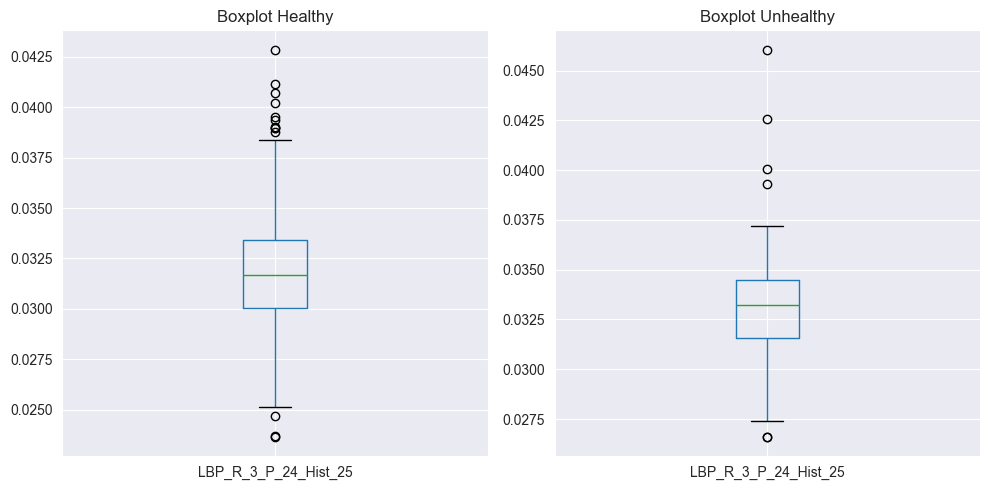

In [212]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

features_healthy_ant_norm[['LBP_R_3_P_24_Hist_25']].boxplot(ax=axs[0])
axs[0].set_title('Boxplot Healthy')

features_insufficiency_ant_norm[['LBP_R_3_P_24_Hist_25']].boxplot(ax=axs[1])
axs[1].set_title('Boxplot Unhealthy')

plt.tight_layout()
plt.show()

In [8]:
significant_features(features_healthy_ant_norm_no_lbp, features_insufficiency_ant_norm_no_lbp, levene_results_ant_norm_no_lbp, healthy_shapiro_results_ant_norm_no_lbp,insufficiency_shapiro_results_ant_norm_no_lbp) 

[]

In [50]:
significant_ant_norm2 = significant_features(features_healthy_ant_norm2, 
                                       features_insufficiency_ant_norm2, 
                                       levene_results_ant_norm2, 
                                       healthy_shapiro_results_ant_norm2, 
                                       insufficiency_shapiro_results_ant_norm2)
significant_ant_norm2

[('LBP_R_1_P_8_Hist_7', 0.0071112282663520435, True),
 ('LBP_R_3_P_24_Hist_25', 0.0071112282663520435, True),
 ('LBP_R_1_P_8_Hist_5', 0.007715879949216256, True),
 ('LBP_R_2_P_16_Hist_9', 0.01018926887586376, True),
 ('LBP_R_3_P_24_Hist_1', 0.01028813817177986, True),
 ('LBP_R_3_P_24_Hist_13', 0.01028813817177986, True),
 ('LBP_R_2_P_16_Hist_1', 0.032651474610738314, True)]

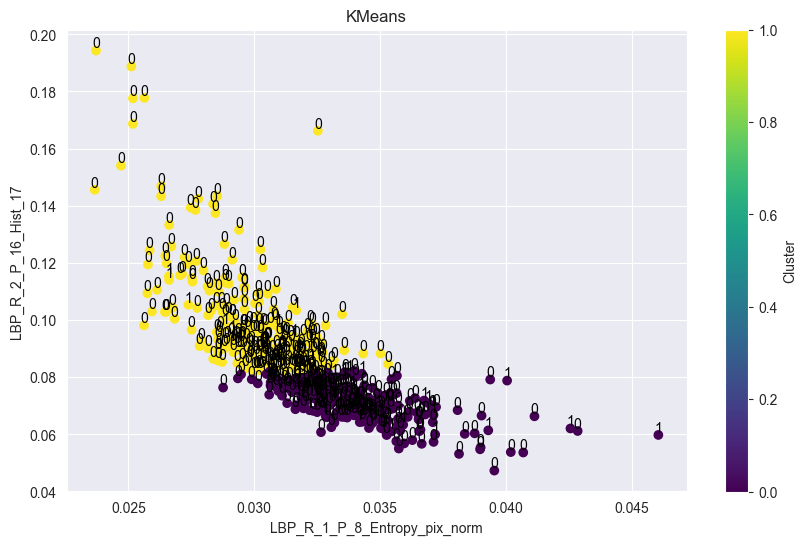

In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init="random", n_init=1, algorithm="full", max_iter=1, random_state=0)
kmeans.fit(features_ant_norm2[['LBP_R_3_P_24_Hist_25', 'LBP_R_3_P_24_Hist_13']])

features_ant_norm2['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_ant_norm2['LBP_R_3_P_24_Hist_25'], features_ant_norm2['LBP_R_3_P_24_Hist_13'], 
                      c=features_ant_norm2['cluster'], cmap='viridis', marker='o')

for i in range(len(features_ant_norm2)):
    plt.text(features_ant_norm2.iloc[i]['LBP_R_3_P_24_Hist_25'], 
             features_ant_norm2.iloc[i]['LBP_R_3_P_24_Hist_13'], 
             str(features_ant_norm2.iloc[i]['Label']), 
             fontdict=dict(color='black'), ha='center', va='bottom')

plt.title("KMeans")
plt.xlabel("LBP_R_1_P_8_Entropy_pix_norm")
plt.ylabel("LBP_R_2_P_16_Hist_17")
plt.colorbar(scatter, label='Cluster')
plt.show()

In [12]:
significant_features(features_healthy_ant_norm2_no_lbp, features_insufficiency_ant_norm2_no_lbp, levene_results_ant_norm2_no_lbp, healthy_shapiro_results_ant_norm2_no_lbp,insufficiency_shapiro_results_ant_norm2_no_lbp)

[]

In [52]:
significant_ant_norm3 = significant_features(features_healthy_ant_norm3, 
                                       features_insufficiency_ant_norm3, 
                                       levene_results_ant_norm3, 
                                       healthy_shapiro_results_ant_norm3, 
                                       insufficiency_shapiro_results_ant_norm3)
significant_ant_norm3

[]

In [14]:
significant_features(features_healthy_ant_norm3_no_lbp, features_insufficiency_ant_norm3_no_lbp, levene_results_ant_norm3_no_lbp, healthy_shapiro_results_ant_norm3_no_lbp,insufficiency_shapiro_results_ant_norm3_no_lbp)

[]

In [54]:
significant_ant_norm4 = significant_features(features_healthy_ant_norm4, 
                                       features_insufficiency_ant_norm4, 
                                       levene_results_ant_norm4, 
                                       healthy_shapiro_results_ant_norm4, 
                                       insufficiency_shapiro_results_ant_norm4)
significant_ant_norm4

[('LBP_R_1_P_8_Hist_7', 0.0071112282663520435, True),
 ('LBP_R_3_P_24_Hist_25', 0.0071112282663520435, True),
 ('LBP_R_1_P_8_Hist_5', 0.007715879949216256, True),
 ('LBP_R_2_P_16_Hist_9', 0.01018926887586376, True),
 ('LBP_R_3_P_24_Hist_1', 0.01028813817177986, True),
 ('LBP_R_3_P_24_Hist_13', 0.01028813817177986, True),
 ('LBP_R_2_P_16_Hist_1', 0.032651474610738314, True)]

In [16]:
significant_features(features_healthy_ant_norm4_no_lbp, features_insufficiency_ant_norm4_no_lbp, levene_results_ant_norm4_no_lbp, healthy_shapiro_results_ant_norm4_no_lbp,insufficiency_shapiro_results_ant_norm4_no_lbp)

[]

In [41]:
significant_ant_norm5 = significant_features(features_healthy_ant_norm5, 
                                       features_insufficiency_ant_norm5, 
                                       levene_results_ant_norm5, 
                                       healthy_shapiro_results_ant_norm5, 
                                       insufficiency_shapiro_results_ant_norm5)
significant_ant_norm5

[]

In [25]:
significant_features(features_healthy_ant_lbp_norm5, features_insufficiency_ant_lbp_norm5, levene_results_ant_lbp_norm5, healthy_shapiro_results_ant_lbp_norm5,insufficiency_shapiro_results_ant_lbp_norm5)

[('LBP_R_2_P_16_Hist_16', 0.029569637722611845, True),
 ('LBP_R_3_P_24_Hist_24', 0.029569637722611845, True),
 ('LBP_R_2_P_16_Hist_12', 0.03152341730102591, True)]

In [63]:
significant_ant_norm6 = significant_features(features_healthy_ant_norm6, features_insufficiency_ant_norm6, levene_results_ant_norm6, healthy_shapiro_results_ant_norm6,insufficiency_shapiro_results_ant_norm6)
significant_ant_norm6

[('LBP_R_1_P_8_Hist_7', 0.0071112282663520435, True),
 ('LBP_R_3_P_24_Hist_25', 0.0071112282663520435, True),
 ('LBP_R_1_P_8_Hist_5', 0.007715879949216256, True),
 ('LBP_R_2_P_16_Hist_9', 0.01018926887586376, True),
 ('LBP_R_3_P_24_Hist_1', 0.01028813817177986, True),
 ('LBP_R_3_P_24_Hist_13', 0.01028813817177986, True),
 ('LBP_R_2_P_16_Hist_1', 0.032651474610738314, True)]

In [19]:
significant_features(features_healthy_ant_norm6_no_lbp, features_insufficiency_ant_norm6_no_lbp, levene_results_ant_norm6_no_lbp, healthy_shapiro_results_ant_norm6_no_lbp,insufficiency_shapiro_results_ant_norm6_no_lbp)

[]

In [65]:
significant_ant_norm7 = significant_features(features_healthy_ant_norm7, 
                                       features_insufficiency_ant_norm7, 
                                       levene_results_ant_norm7, 
                                       healthy_shapiro_results_ant_norm7, 
                                       insufficiency_shapiro_results_ant_norm7)
significant_ant_norm7

[('LBP_R_1_P_8_Hist_7', 0.0071112282663520435, True),
 ('LBP_R_3_P_24_Hist_25', 0.0071112282663520435, True),
 ('LBP_R_1_P_8_Hist_5', 0.007715879949216256, True),
 ('LBP_R_2_P_16_Hist_9', 0.01018926887586376, True),
 ('LBP_R_3_P_24_Hist_1', 0.01028813817177986, True),
 ('LBP_R_3_P_24_Hist_13', 0.01028813817177986, True),
 ('LBP_R_2_P_16_Hist_1', 0.032651474610738314, True)]

In [20]:
significant_features(features_healthy_ant_norm7_no_lbp, features_insufficiency_ant_norm7_no_lbp, levene_results_ant_norm7_no_lbp, healthy_shapiro_results_ant_norm7_no_lbp,insufficiency_shapiro_results_ant_norm7_no_lbp)

[]

In [67]:
significant_ant_norm8 = significant_features(features_healthy_ant_norm8, features_insufficiency_ant_norm8, levene_results_ant_norm8, healthy_shapiro_results_ant_norm8,insufficiency_shapiro_results_ant_norm8)
significant_ant_norm8

[('LBP_R_1_P_8_Hist_7', 0.0071112282663520435, True),
 ('LBP_R_3_P_24_Hist_25', 0.0071112282663520435, True),
 ('LBP_R_1_P_8_Hist_5', 0.007715879949216256, True),
 ('LBP_R_2_P_16_Hist_9', 0.01018926887586376, True),
 ('LBP_R_3_P_24_Hist_1', 0.01028813817177986, True),
 ('LBP_R_3_P_24_Hist_13', 0.01028813817177986, True),
 ('LBP_R_2_P_16_Hist_1', 0.032651474610738314, True)]

In [22]:
significant_features(features_healthy_ant_norm8_no_lbp, features_insufficiency_ant_norm8_no_lbp, levene_results_ant_norm8_no_lbp, healthy_shapiro_results_ant_norm8_no_lbp,insufficiency_shapiro_results_ant_norm8_no_lbp)

[]

In [69]:
significant_ant_norm9 = significant_features(features_healthy_ant_norm9, features_insufficiency_ant_norm9, levene_results_ant_norm9, healthy_shapiro_results_ant_norm9,insufficiency_shapiro_results_ant_norm9)
significant_ant_norm9

[('LBP_R_1_P_8_Hist_7', 0.0071112282663520435, True),
 ('LBP_R_3_P_24_Hist_25', 0.0071112282663520435, True),
 ('LBP_R_1_P_8_Hist_5', 0.007715879949216256, True),
 ('LBP_R_2_P_16_Hist_9', 0.01018926887586376, True),
 ('LBP_R_3_P_24_Hist_1', 0.01028813817177986, True),
 ('LBP_R_3_P_24_Hist_13', 0.01028813817177986, True),
 ('LBP_R_2_P_16_Hist_1', 0.032651474610738314, True)]

In [25]:
significant_features(features_healthy_ant_norm9_no_lbp, features_insufficiency_ant_norm9_no_lbp, levene_results_ant_norm9_no_lbp, healthy_shapiro_results_ant_norm9_no_lbp,insufficiency_shapiro_results_ant_norm9_no_lbp)

[]

In [71]:
significant_ant_3sigma6_norm = significant_features(features_healthy_ant_3sigma6_norm, features_insufficiency_ant_3sigma6_norm, levene_results_ant_3sigma6_norm,healthy_shapiro_results_ant_3sigma6_norm, insufficiency_shapiro_results_ant_3sigma6_norm)
significant_ant_3sigma6_norm

[('GLCM_Contrast_d1', 0.026031557905665696, True),
 ('GLCM_Correlation_d1', 0.026031557905665696, True),
 ('GLCM_Inverse_Difference_Moment_d1', 0.026031557905665696, True),
 ('GLCM_Entropy_d1', 0.026031557905665696, True),
 ('GLCM_Difference_Variance_d1', 0.026031557905665696, True),
 ('GLCM_Difference_Entropy_d1', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation1_d1', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation2_d1', 0.026031557905665696, True),
 ('GLCM_Contrast_d2', 0.026031557905665696, True),
 ('GLCM_Correlation_d2', 0.026031557905665696, True),
 ('GLCM_Inverse_Difference_Moment_d2', 0.026031557905665696, True),
 ('GLCM_Entropy_d2', 0.026031557905665696, True),
 ('GLCM_Difference_Variance_d2', 0.026031557905665696, True),
 ('GLCM_Difference_Entropy_d2', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation1_d2', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation2_d2', 0.026031557905665696, Tru

In [73]:
significant_ant_3sigma6_int_norm = significant_features(features_healthy_ant_3sigma6_int_norm, features_insufficiency_ant_3sigma6_int_norm, levene_results_ant_3sigma6_int_norm,healthy_shapiro_results_ant_3sigma6_int_norm, insufficiency_shapiro_results_ant_3sigma6_int_norm)
significant_ant_3sigma6_int_norm

[('LBP_R_1_P_8_Hist_7', 0.015378590637057127, True),
 ('LBP_R_2_P_16_Hist_9', 0.015378590637057127, True),
 ('LBP_R_3_P_24_Hist_13', 0.020413607409282594, True),
 ('LBP_R_3_P_24_Hist_1', 0.020818952610264625, True)]

In [81]:
significant_ant_3sigma6_resegment_norm = significant_features(features_healthy_ant_3sigma6_resegment_norm, features_insufficiency_ant_3sigma6_resegment_norm, levene_results_ant_3sigma6_resegment_norm,healthy_shapiro_results_ant_3sigma6_resegment_norm, insufficiency_shapiro_results_ant_3sigma6_resegment_norm)
significant_ant_3sigma6_resegment_norm

[('GLCM_Inverse_Difference_Moment_d1', 0.026536016531974068, True),
 ('GLCM_Entropy_d1', 0.026536016531974068, True),
 ('GLCM_Difference_Variance_d1', 0.026536016531974068, True),
 ('GLCM_Difference_Entropy_d1', 0.026536016531974068, True),
 ('GLCM_Information_Measure_of_Correlation1_d1', 0.026536016531974068, True),
 ('GLCM_Information_Measure_of_Correlation2_d1', 0.026536016531974068, True),
 ('GLCM_Contrast_d2', 0.026536016531974068, True),
 ('GLCM_Correlation_d2', 0.026536016531974068, True),
 ('GLCM_Inverse_Difference_Moment_d2', 0.026536016531974068, True),
 ('GLCM_Sum_Entropy_d2', 0.026536016531974068, True),
 ('GLCM_Entropy_d2', 0.026536016531974068, True),
 ('GLCM_Difference_Variance_d2', 0.026536016531974068, True),
 ('GLCM_Difference_Entropy_d2', 0.026536016531974068, True),
 ('GLCM_Information_Measure_of_Correlation1_d2', 0.026536016531974068, True),
 ('GLCM_Information_Measure_of_Correlation2_d2', 0.026536016531974068, True),
 ('GLCM_Contrast_d3', 0.026536016531974068, Tru

In [29]:
significant_ant_3sigma7_norm = significant_features(features_healthy_ant_3sigma7_norm, features_insufficiency_ant_3sigma7_norm, levene_results_ant_3sigma7_norm,healthy_shapiro_results_ant_3sigma7_norm, insufficiency_shapiro_results_ant_3sigma7_norm)
significant_ant_3sigma7_norm

[('GLCM_Contrast_d1', 0.026031557905665696, True),
 ('GLCM_Correlation_d1', 0.026031557905665696, True),
 ('GLCM_Inverse_Difference_Moment_d1', 0.026031557905665696, True),
 ('GLCM_Entropy_d1', 0.026031557905665696, True),
 ('GLCM_Difference_Variance_d1', 0.026031557905665696, True),
 ('GLCM_Difference_Entropy_d1', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation1_d1', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation2_d1', 0.026031557905665696, True),
 ('GLCM_Contrast_d2', 0.026031557905665696, True),
 ('GLCM_Correlation_d2', 0.026031557905665696, True),
 ('GLCM_Inverse_Difference_Moment_d2', 0.026031557905665696, True),
 ('GLCM_Entropy_d2', 0.026031557905665696, True),
 ('GLCM_Difference_Variance_d2', 0.026031557905665696, True),
 ('GLCM_Difference_Entropy_d2', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation1_d2', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation2_d2', 0.026031557905665696, Tru

In [30]:
len(significant_ant_3sigma7_norm)

81

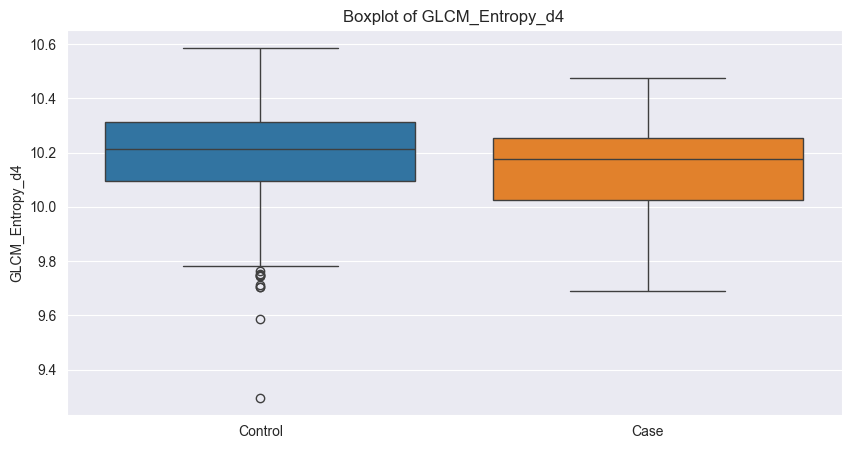

In [45]:
combined_data = pd.DataFrame({
    'Control': features_healthy_ant_3sigma7_norm['GLCM_Entropy_d4'],
    'Case': features_insufficiency_ant_3sigma7_norm['GLCM_Entropy_d4']
})

plt.figure(figsize=(10, 5))
sns.boxplot(data=combined_data)

plt.title('Boxplot of GLCM_Entropy_d4')
plt.ylabel('GLCM_Entropy_d4')
plt.show()

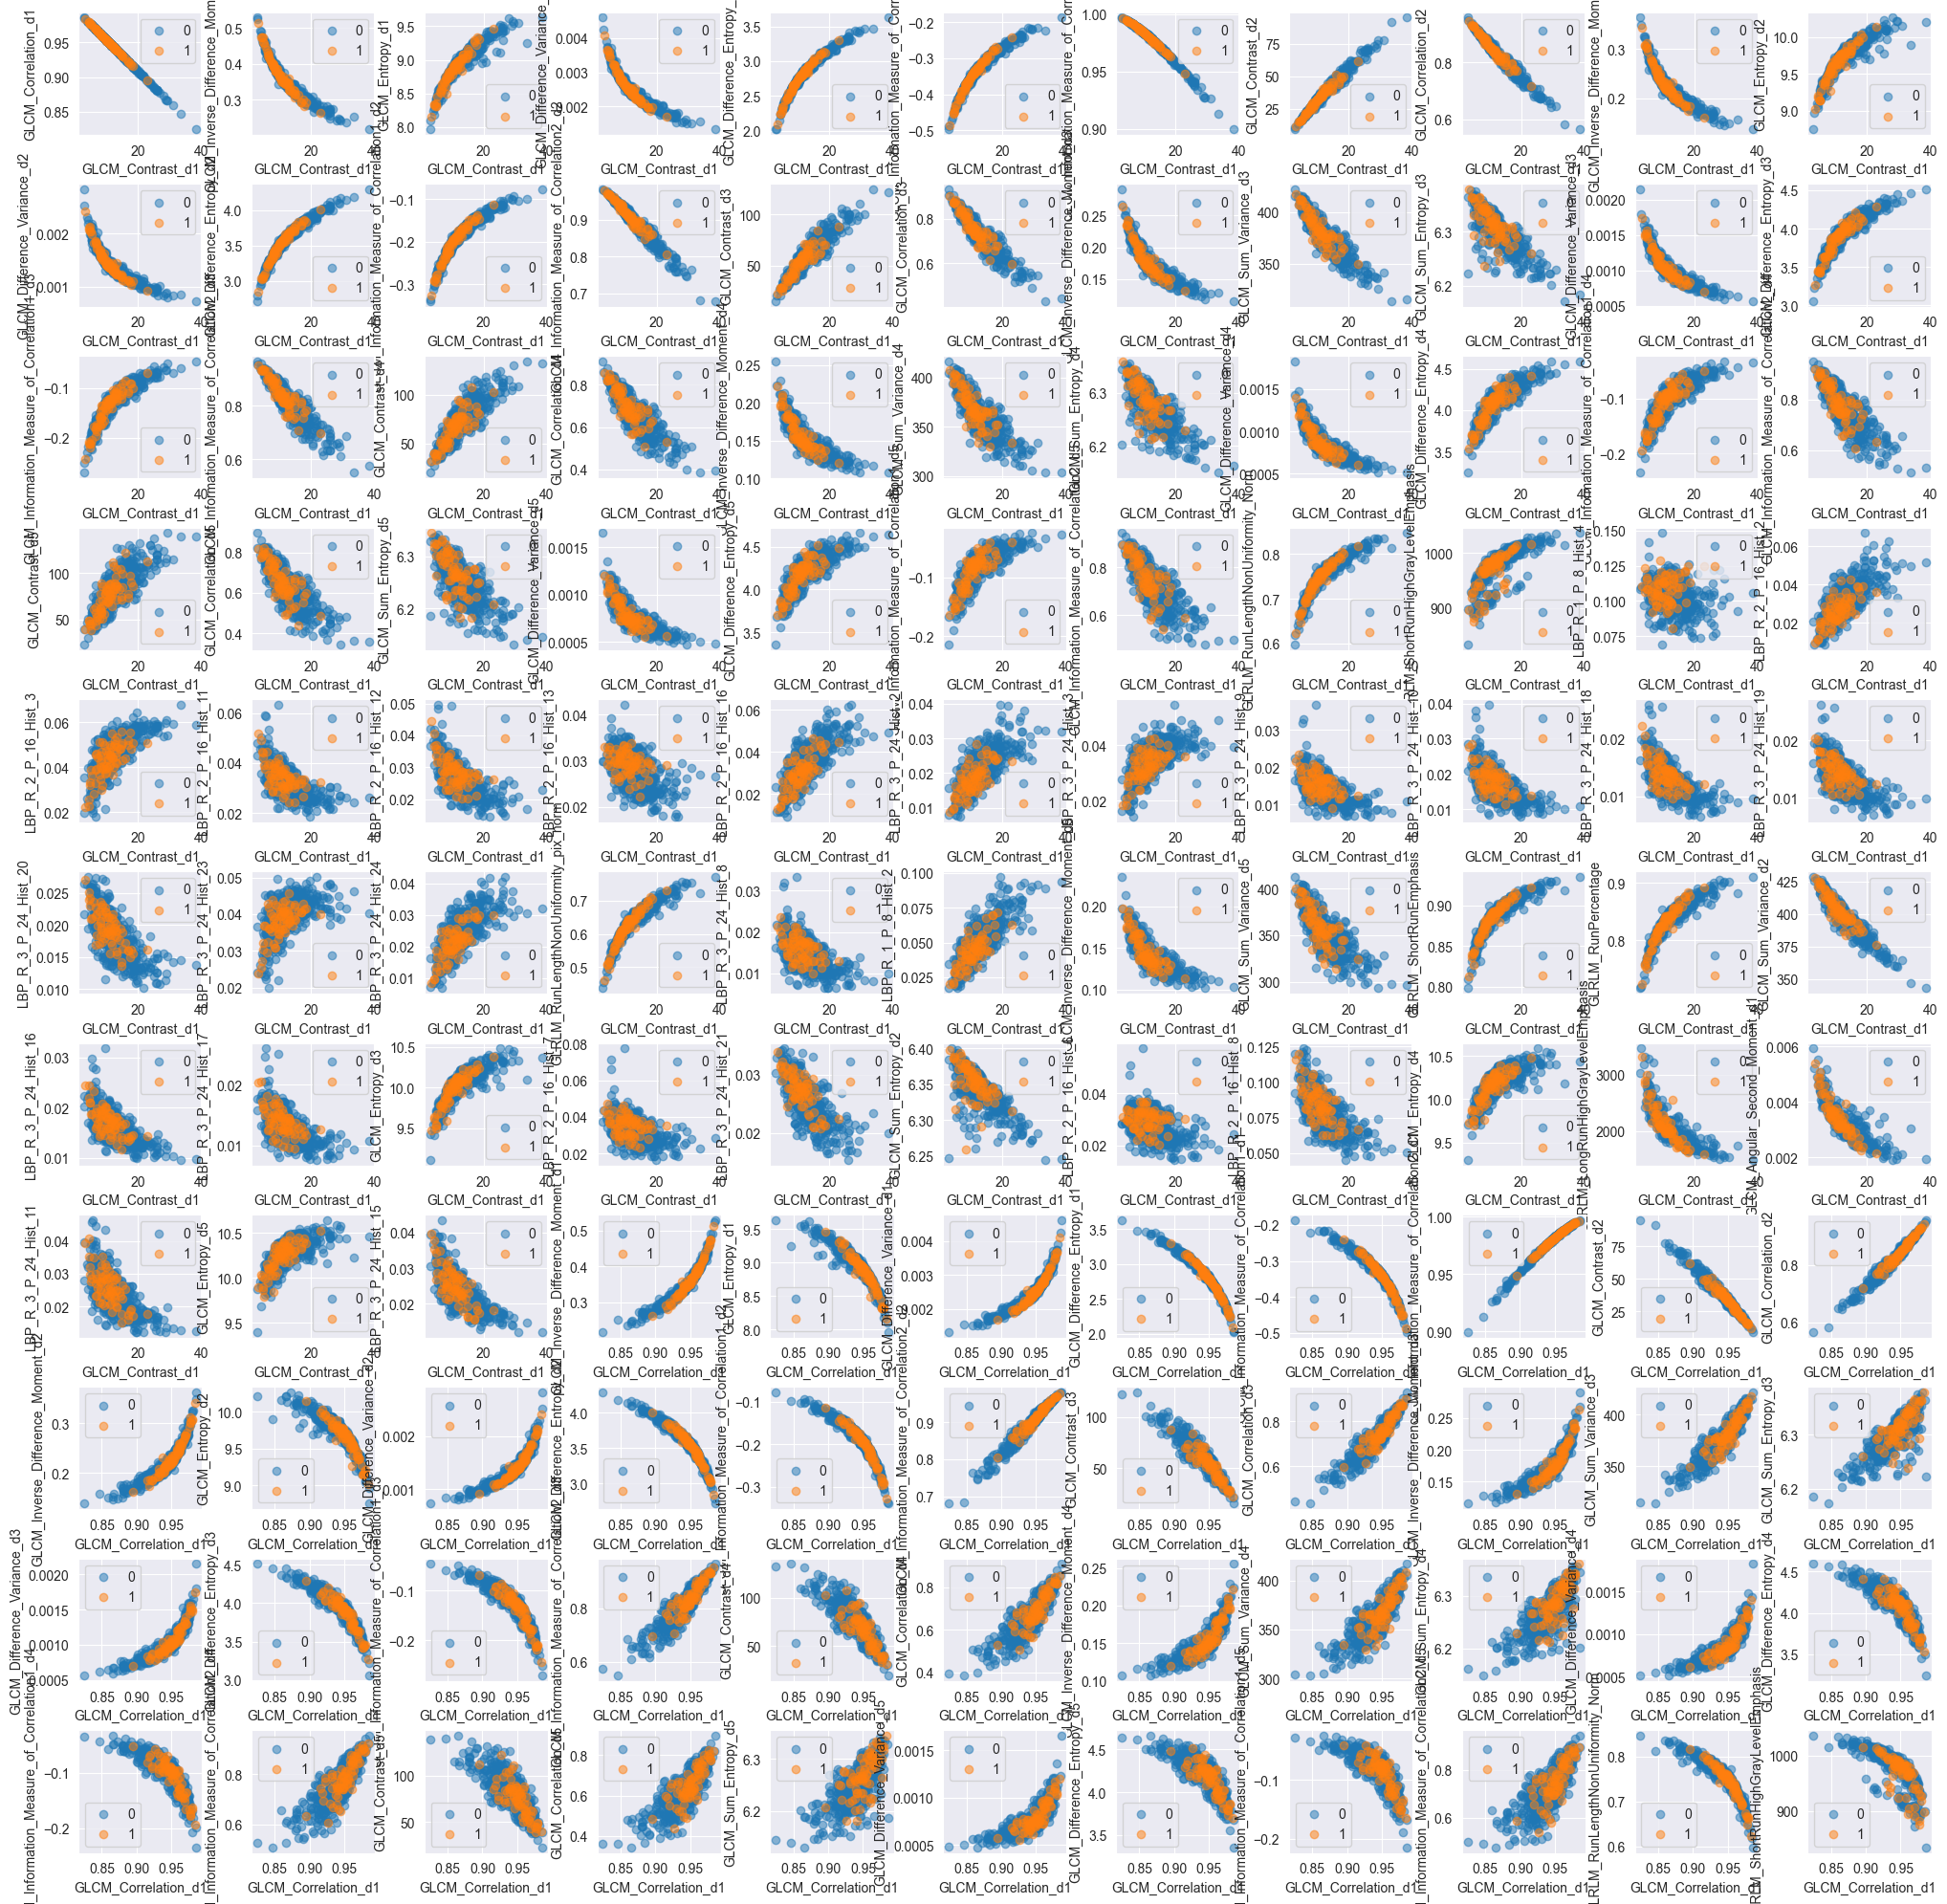

In [93]:
plot_scatter(significant_ant_3sigma7_norm, features_ant_3sigma7_norm)

In [85]:
significant_ant_3sigma_7_int_norm = significant_features(features_healthy_ant_3sigma_7_int_norm, features_insufficiency_ant_3sigma_7_int_norm, levene_results_ant_3sigma_7_int_norm,healthy_shapiro_results_ant_3sigma_7_int_norm, insufficiency_shapiro_results_ant_3sigma_7_int_norm)
significant_ant_3sigma_7_int_norm

[('LBP_R_1_P_8_Hist_7', 0.009729097748056218, True),
 ('LBP_R_2_P_16_Hist_9', 0.015825870359458934, True),
 ('LBP_R_3_P_24_Hist_1', 0.015825870359458934, True),
 ('LBP_R_3_P_24_Hist_13', 0.015825870359458934, True),
 ('LBP_R_1_P_8_Hist_5', 0.019373867860502002, True),
 ('LBP_R_3_P_24_Hist_25', 0.019373867860502002, True),
 ('LBP_R_2_P_16_Hist_14', 0.042862783334780434, True),
 ('LBP_R_3_P_24_Hist_14', 0.042862783334780434, True)]

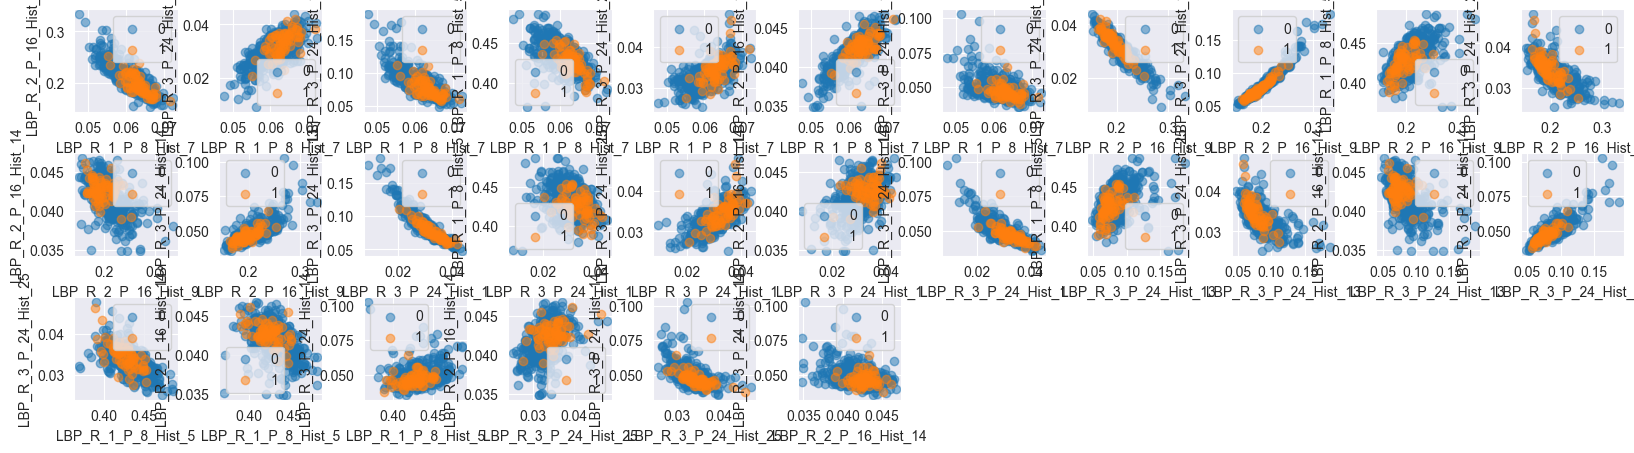

In [90]:
plot_scatter(significant_ant_3sigma_7_int_norm, features_ant_3sigma_7_int_norm)

In [95]:
significant_ant_3sigma8_norm = significant_features(features_healthy_ant_3sigma8_norm, 
                                       features_insufficiency_ant_3sigma8_norm, 
                                       levene_results_ant_3sigma8_norm, 
                                       healthy_shapiro_results_ant_3sigma8_norm, 
                                       insufficiency_shapiro_results_ant_3sigma8_norm)
significant_ant_3sigma8_norm

[('GLCM_Contrast_d1', 0.026031557905665696, True),
 ('GLCM_Correlation_d1', 0.026031557905665696, True),
 ('GLCM_Inverse_Difference_Moment_d1', 0.026031557905665696, True),
 ('GLCM_Entropy_d1', 0.026031557905665696, True),
 ('GLCM_Difference_Variance_d1', 0.026031557905665696, True),
 ('GLCM_Difference_Entropy_d1', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation1_d1', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation2_d1', 0.026031557905665696, True),
 ('GLCM_Contrast_d2', 0.026031557905665696, True),
 ('GLCM_Correlation_d2', 0.026031557905665696, True),
 ('GLCM_Inverse_Difference_Moment_d2', 0.026031557905665696, True),
 ('GLCM_Entropy_d2', 0.026031557905665696, True),
 ('GLCM_Difference_Variance_d2', 0.026031557905665696, True),
 ('GLCM_Difference_Entropy_d2', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation1_d2', 0.026031557905665696, True),
 ('GLCM_Information_Measure_of_Correlation2_d2', 0.026031557905665696, Tru

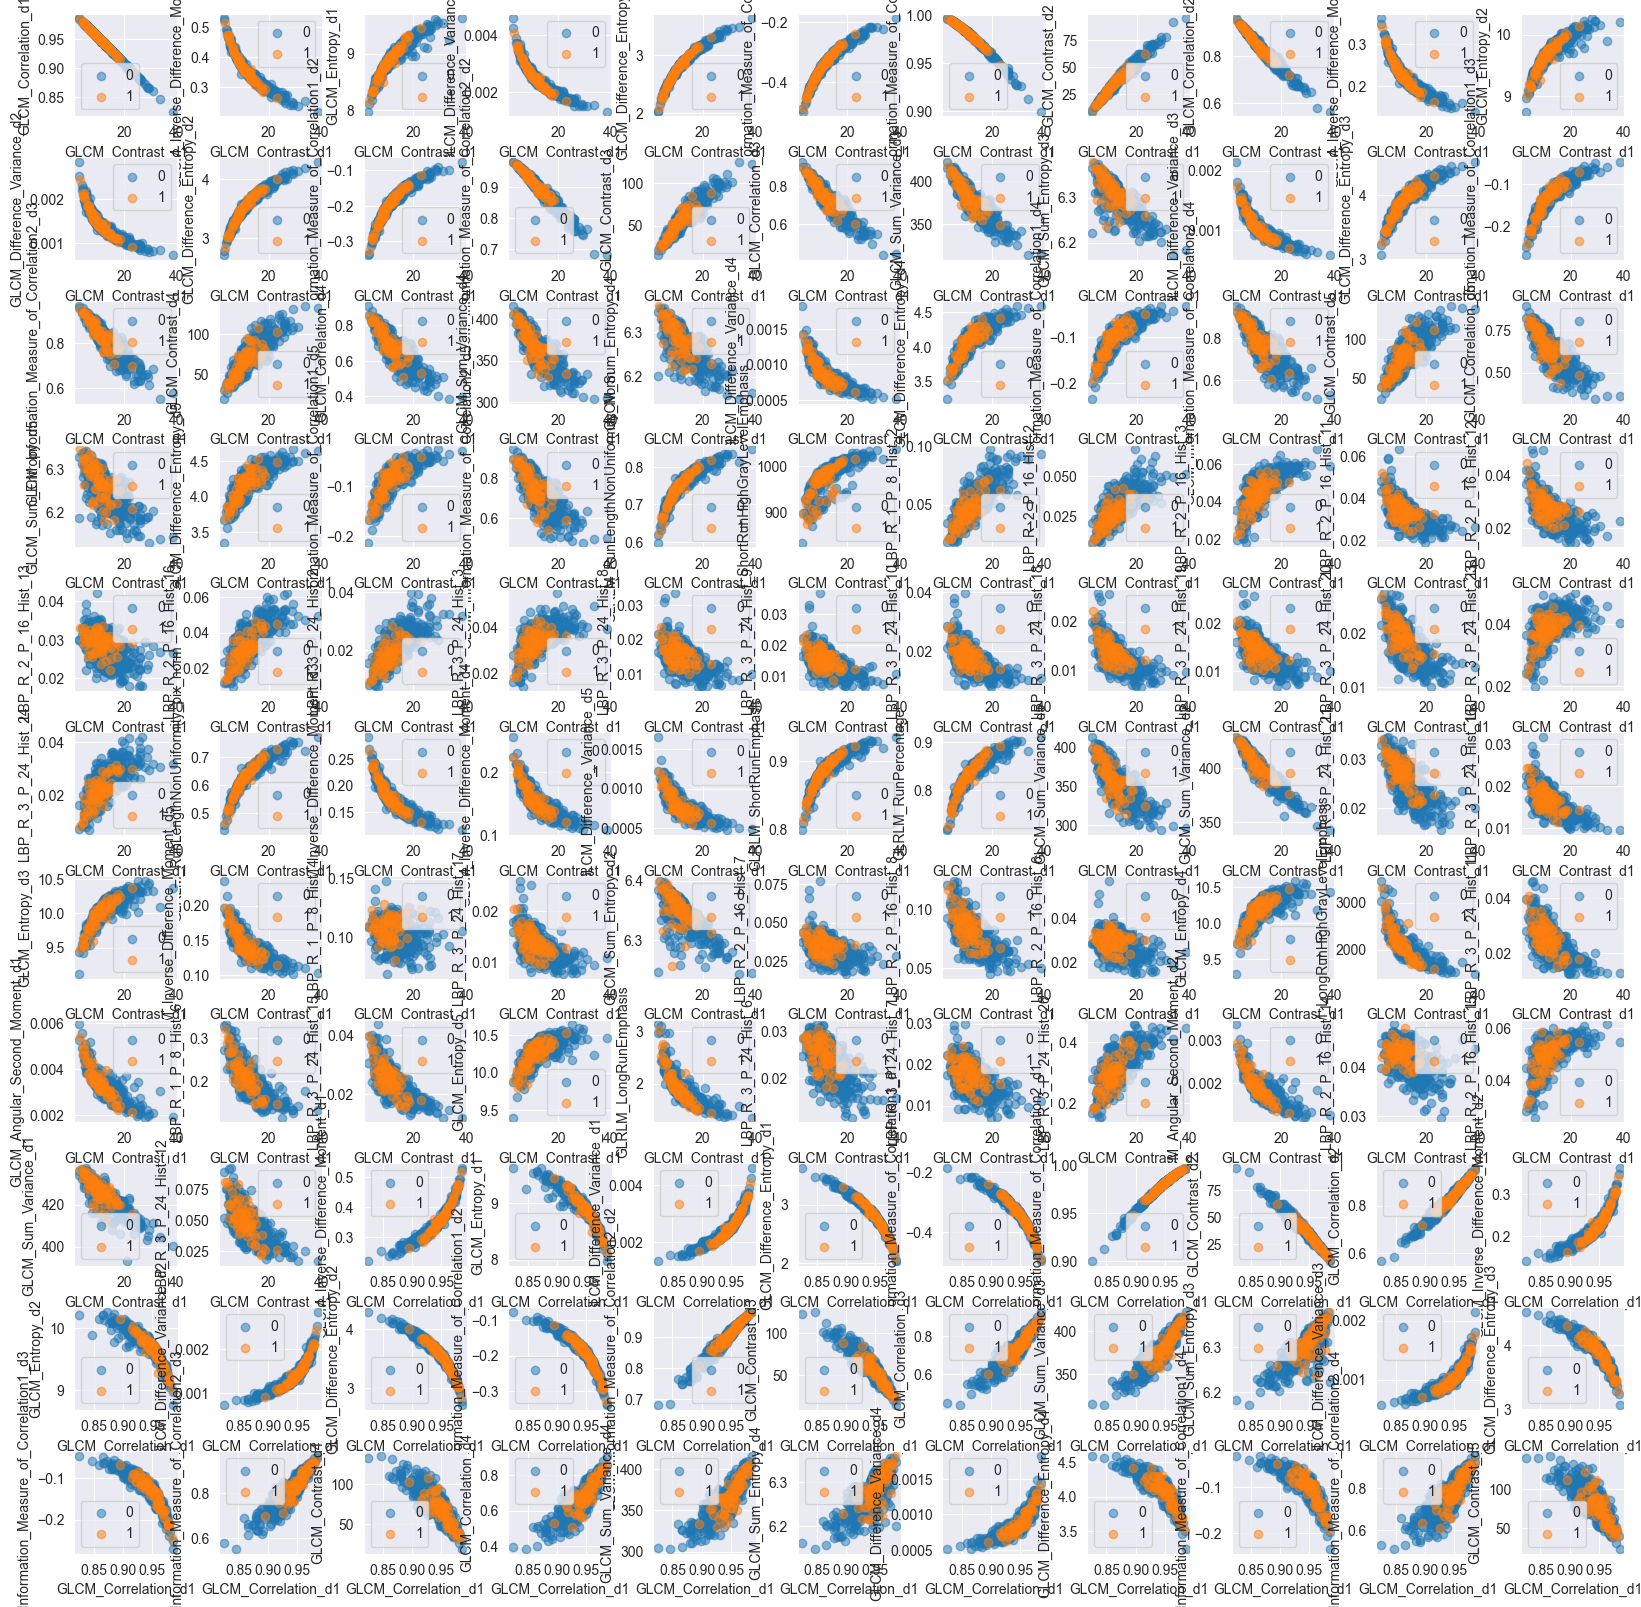

In [37]:
plot_scatter(significant_ant_3sigma8_norm, features_ant_3sigma8_norm)

In [106]:
significant_ant_3sigma8_int_norm = significant_features(features_healthy_ant_3sigma8_int_norm, 
                                       features_insufficiency_ant_3sigma8_int_norm, 
                                       levene_results_ant_3sigma8_int_norm, 
                                       healthy_shapiro_results_ant_3sigma8_int_norm, 
                                       insufficiency_shapiro_results_ant_3sigma8_int_norm)
significant_ant_3sigma8_int_norm

[('LBP_R_1_P_8_Hist_5', 0.010815014689414973, True),
 ('LBP_R_1_P_8_Hist_7', 0.010815014689414973, True),
 ('LBP_R_2_P_16_Hist_9', 0.010815014689414973, True),
 ('LBP_R_3_P_24_Hist_1', 0.010815014689414973, True),
 ('LBP_R_3_P_24_Hist_13', 0.012698835567483656, True),
 ('LBP_R_2_P_16_Hist_1', 0.028479013370605235, True),
 ('LBP_R_3_P_24_Hist_25', 0.028479013370605235, True),
 ('LBP_R_3_P_24_Hist_14', 0.04042723264711709, True)]

In [110]:
significant_ant_3sigma7_int_fgr = significant_features(features_healthy_ant_3sigma7_int_fgr, features_insufficiency_3sigma7_int_fgr, levene_results_3sigma7_int_fgr, healthy_shapiro_results_3sigma7_int_fgr,insufficiency_shapiro_results_ant_3sigma7_int_fgr)
significant_ant_3sigma7_int_fgr

[]

In [112]:
significant_ant_3sigma7_int_fgr_norm = significant_features(features_healthy_ant_3sigma7_int_fgr_norm, features_insufficiency_3sigma7_int_fgr_norm, levene_results_3sigma7_int_fgr_norm, healthy_shapiro_results_3sigma7_int_fgr_norm,insufficiency_shapiro_results_ant_3sigma7_int_fgr_norm)

In [113]:
significant_ant_3sigma7_int_fgr_norm

[]

In [122]:
significant_3sigma_7_int_pe_norm = significant_features(features_healthy_ant_3sigma7_int_pe_norm, features_insufficiency_3sigma7_int_pe_norm, levene_results_3sigma7_int_pe_norm, healthy_shapiro_results_3sigma7_int_pe_norm,insufficiency_shapiro_results_ant_3sigma7_int_pe_norm)
significant_3sigma_7_int_pe_norm

[]

In [123]:
significant_3sigma_7_pe_norm = significant_features(features_healthy_ant_3sigma7_pe_norm, features_insufficiency_3sigma7_pe_norm, levene_results_3sigma7_pe_norm, healthy_shapiro_results_3sigma7_norm,insufficiency_shapiro_results_ant_3sigma7_pe_norm)
significant_3sigma_7_pe_norm

[]

In [136]:
significant_3sigma_7_fgr_norm = significant_features(features_healthy_ant_3sigma7_fgr_norm, features_insufficiency_3sigma7_fgr_norm, levene_results_3sigma7_fgr_norm, healthy_shapiro_results_3sigma7_fgr_norm,insufficiency_shapiro_results_ant_3sigma7_fgr_norm)
significant_3sigma_7_fgr_norm

[]

In [134]:
significant_features(features_healthy_ant_3sigma_raw_norm, features_insufficiency_3sigma_raw_norm, 
levene_results_3sigma_raw_norm, healthy_shapiro_results_3sigma_raw_norm,insufficiency_shapiro_results_ant_3sigma_raw_norm)

[('LBP_R_2_P_16_Hist_16', 0.02917985918217647, True),
 ('LBP_R_3_P_24_Hist_24', 0.02917985918217647, True),
 ('LBP_R_2_P_16_Hist_12', 0.033492881920095675, True),
 ('GLH_10Percentile', 0.03792087989732467, True),
 ('GLCM_Correlation_d1', 0.03792087989732467, True),
 ('GLCM_Information_Measure_of_Correlation1_d1', 0.03792087989732467, True),
 ('GLCM_Information_Measure_of_Correlation2_d1', 0.03792087989732467, True),
 ('GLCM_Correlation_d2', 0.03792087989732467, True),
 ('GLCM_Information_Measure_of_Correlation1_d2', 0.03792087989732467, True),
 ('GLCM_Information_Measure_of_Correlation2_d2', 0.03792087989732467, True),
 ('GLCM_Correlation_d3', 0.03792087989732467, True),
 ('GLCM_Information_Measure_of_Correlation1_d3', 0.03792087989732467, True),
 ('GLCM_Information_Measure_of_Correlation2_d3', 0.03792087989732467, True),
 ('GLCM_Correlation_d4', 0.03792087989732467, True),
 ('GLCM_Information_Measure_of_Correlation1_d4', 0.03792087989732467, True),
 ('GLCM_Information_Measure_of_Corre

In [139]:
significant_features(my_df_3sigma_raw_fgr_healthy_norm, my_df_3sigma_raw_fgr_ins_norm, levene_my_df_3sigma_raw_fgr_norm, healthy_shapiro_my_df_3sigma_raw_fgr_norm,insufficiency_shapiro_my_df_3sigma_raw_fgr_norm)

[('GLCM_Difference_Variance_d1', 0.026418573624812654, True),
 ('GLCM_Difference_Variance_d2', 0.026418573624812654, True),
 ('GLCM_Difference_Variance_d3', 0.026418573624812654, True),
 ('GLCM_Inverse_Difference_Moment_d4', 0.026418573624812654, True),
 ('GLCM_Difference_Variance_d4', 0.026418573624812654, True),
 ('GLCM_Inverse_Difference_Moment_d5', 0.026418573624812654, True),
 ('GLCM_Difference_Variance_d5', 0.026418573624812654, True),
 ('GLRLM_ShortRunEmphasis', 0.03459175812286706, True),
 ('GLRLM_RunLengthNonUniformity_Norm', 0.03459175812286706, True),
 ('GLH_10Percentile', 0.03480158750396988, True),
 ('GLH_50Percentile', 0.03480158750396988, True),
 ('GLH_75Percentile', 0.03480158750396988, True),
 ('GLH_90Percentile', 0.03480158750396988, True),
 ('GLCM_Inverse_Difference_Moment_d1', 0.03480158750396988, True),
 ('GLCM_Sum_Average_d1', 0.03480158750396988, True),
 ('GLCM_Inverse_Difference_Moment_d2', 0.03480158750396988, True),
 ('GLCM_Sum_Average_d2', 0.03480158750396988

In [138]:
significant_features(my_df_3sigma_raw_pe_healthy_norm, my_df_3sigma_raw_pe_ins_norm, levene_my_df_3sigma_raw_pe_norm, healthy_shapiro_my_df_3sigma_raw_pe_norm,insufficiency_shapiro_my_df_3sigma_raw_pe_norm)

[]

In [64]:
significant_ant_3_pe_norm = significant_features(features_healthy_ant_3_pe_norm, features_insufficiency_ant_3_pe_norm, levene_results_ant_3_pe_norm, healthy_shapiro_results_ant_3_pe_norm,insufficiency_shapiro_results_ant_3_pe_norm)
significant_ant_3_pe_norm

[]

In [159]:
significant_ant_3_fgr_norm = significant_features(features_healthy_ant_3_fgr_norm, features_insufficiency_ant_3_fgr_norm, levene_results_ant_3_fgr_norm, healthy_shapiro_results_ant_3_fgr_norm,insufficiency_shapiro_results_ant_3_fgr_norm)
significant_ant_3_fgr_norm

[('original_firstorder_Mean', 0.031762248978419796, True),
 ('original_firstorder_RootMeanSquared', 0.031762248978419796, True),
 ('original_firstorder_10Percentile', 0.031762248978419796, True),
 ('original_firstorder_90Percentile', 0.031762248978419796, True),
 ('original_firstorder_Median', 0.031762248978419796, True),
 ('original_glcm_Contrast', 0.031762248978419796, True),
 ('original_glcm_DifferenceAverage', 0.031762248978419796, True),
 ('original_glcm_DifferenceEntropy', 0.031762248978419796, True),
 ('original_glcm_DifferenceVariance', 0.031762248978419796, True),
 ('original_glcm_Id', 0.031762248978419796, True),
 ('original_glcm_Idm', 0.031762248978419796, True),
 ('original_glrlm_RunLengthNonUniformityNormalized',
  0.031762248978419796,
  True),
 ('original_glrlm_RunPercentage', 0.031762248978419796, True),
 ('original_glrlm_ShortRunEmphasis', 0.031762248978419796, True),
 ('original_glszm_LargeAreaLowGrayLevelEmphasis', 0.031762248978419796, True),
 ('original_firstorder_

In [30]:
significant_features(healthy_features_3_fgr_lbp_norm, insufficiency_features_3_fgr_lbp_norm, levene_results_features_3_fgr_lbp_norm, healthy_shapiro_results_features_3_fgr_lbp_norm,insufficiency_shapiro_results_features_3_fgr_lbp_norm )

[]

In [23]:
significant_ant_5_fgr_norm = significant_features(healthy_ant_features_5_fgr_pix_norm, insufficiency_ant_features_5_fgr_pix_norm, levene_results_ant_features_5_fgr_pix_norm, healthy_shapiro_results_ant_features_5_fgr_pix_norm,insufficiency_shapiro_results_ant_features_5_fgr_pix_norm)

In [24]:
significant_ant_5_fgr_norm

[]

In [27]:
significant_features(healthy_ant_features_5_lbp_fgr_pix_norm, insufficiency_ant_features_5_fgr_lbp_pix_norm, levene_results_ant_features_5_lbp_fgr_pix_norm, healthy_shapiro_results_ant_features_5_lbp_fgr_pix_norm,insufficiency_shapiro_results_ant_features_5_lbp_fgr_pix_norm)

[]

In [170]:
significant_ant_1_pe_norm = significant_features(features_healthy_ant_1_pe_norm, features_insufficiency_ant_1_pe_norm, levene_results_ant_1_pe_norm, healthy_shapiro_results_ant_1_pe_norm,insufficiency_shapiro_results_ant_1_pe_norm)
significant_ant_1_pe_norm

[]

In [144]:
significant_ant_1_fgr_norm = significant_features(features_healthy_ant_1_fgr_norm, features_insufficiency_ant_1_fgr_norm, levene_results_ant_1_fgr_norm, healthy_shapiro_results_ant_1_fgr_norm,insufficiency_shapiro_results_ant_1_fgr_norm)
significant_ant_1_fgr_norm

[]

In [149]:
significant_ant_2_fgr_norm = significant_features(features_healthy_ant_2_fgr_norm, features_insufficiency_ant_2_fgr_norm, levene_results_ant_2_fgr_norm, healthy_shapiro_results_ant_2_fgr_norm,insufficiency_shapiro_results_ant_2_fgr_norm)
significant_ant_2_fgr_norm

[]

In [71]:
significant_ant_2_pe_norm = significant_features(features_healthy_ant_2_pe_norm, features_insufficiency_ant_2_pe_norm, levene_results_ant_2_pe_norm, healthy_shapiro_results_ant_2_pe_norm,insufficiency_shapiro_results_ant_2_pe_norm)
significant_ant_2_pe_norm

[]

In [185]:
significant_ant_lbp = significant_features(features_healthy_ant_lbp, features_insufficiency_ant_lbp, levene_results_ant_lbp, healthy_shapiro_results_ant_lbp,insufficiency_shapiro_results_ant_lbp)
significant_ant_lbp

[('LBP_R_2_P_16_Hist_16', 0.01344074441936902, True),
 ('LBP_R_3_P_24_Hist_24', 0.01344074441936902, True),
 ('LBP_R_2_P_16_Hist_12', 0.014328826045920867, True),
 ('LBP_R_1_P_8_Hist_2', 0.03353293178989448, True),
 ('LBP_R_1_P_8_Hist_8', 0.03353293178989448, True),
 ('LBP_R_2_P_16_Hist_2', 0.03353293178989448, True),
 ('LBP_R_2_P_16_Hist_3', 0.03353293178989448, True),
 ('LBP_R_2_P_16_Hist_6', 0.03353293178989448, True),
 ('LBP_R_2_P_16_Hist_7', 0.03353293178989448, True),
 ('LBP_R_2_P_16_Hist_11', 0.03353293178989448, True),
 ('LBP_R_2_P_16_Hist_13', 0.03353293178989448, True),
 ('LBP_R_3_P_24_Hist_2', 0.03353293178989448, True),
 ('LBP_R_3_P_24_Hist_3', 0.03353293178989448, True),
 ('LBP_R_3_P_24_Hist_8', 0.03353293178989448, True),
 ('LBP_R_3_P_24_Hist_9', 0.03353293178989448, True),
 ('LBP_R_3_P_24_Hist_10', 0.03353293178989448, True),
 ('LBP_R_3_P_24_Hist_18', 0.03353293178989448, True),
 ('LBP_R_3_P_24_Hist_19', 0.03353293178989448, True),
 ('LBP_R_3_P_24_Hist_20', 0.03353293178

In [155]:
significant_ant_lbp_fgr_norm = significant_features(features_healthy_ant_lbp_fgr_norm, features_insufficiency_ant_lbp_fgr_norm, levene_results_ant_lbp_fgr_norm, healthy_shapiro_results_ant_lbp_fgr_norm,insufficiency_shapiro_results_ant_lbp_fgr_norm) 
significant_ant_lbp_fgr_norm

[]

In [153]:
significant_ant_lbp_pe_norm = significant_features(features_healthy_ant_lbp_pe_norm, features_insufficiency_ant_lbp_pe_norm, levene_results_ant_lbp_pe_norm, healthy_shapiro_results_ant_lbp_pe_norm,insufficiency_shapiro_results_ant_lbp_pe_norm)
significant_ant_lbp_pe_norm

[]

In [126]:
significant_features(healthy_ant_features_10_fgr_pix_norm, insufficiency_ant_features_10_fgr_pix_norm, levene_results_ant_features_10_fgr_pix_norm, healthy_shapiro_results_ant_features_10_fgr_pix_norm,insufficiency_shapiro_results_ant_features_10_fgr_pix_norm)

[]

In [128]:
significant_features(healthy_features_ant_11_fgr_pix_norm, ins_features_ant_11_fgr_pix_norm, levene_results_features_ant_11_fgr_pix_norm, healthy_shapiro_results_features_ant_11_fgr_pix_norm,insufficiency_shapiro_results_features_ant_11_fgr_pix_norm)

[]

In [131]:
significant_features(healthy_features_ant_12_fgr_pix_norm, ins_features_ant_12_fgr_pix_norm, levene_results_features_ant_12_fgr_pix_norm, healthy_shapiro_results_features_ant_12_fgr_pix_norm,insufficiency_shapiro_results_features_ant_12_fgr_pix_norm)

[]

In [177]:
significant_features(healthy_features_ant_13_pix_norm, ins_features_ant_13_pix_norm, levene_results_features_ant_13_pix_norm, healthy_shapiro_results_features_ant_13_pix_norm,insufficiency_shapiro_results_features_ant_13_pix_norm) 

[]

In [29]:
significant_features(healthy_features_ant_13_pix_norm_no_lbp, ins_features_ant_13_pix_norm_no_lbp, levene_results_features_ant_13_pix_norm_no_lbp, healthy_shapiro_results_features_ant_13_pix_norm_no_lbp,insufficiency_shapiro_results_features_ant_13_pix_norm_no_lbp)

[]

In [179]:
significant_features(healthy_features_ant_14_pix_norm, ins_features_ant_14_pix_norm, levene_results_features_ant_14_pix_norm, healthy_shapiro_results_features_ant_14_pix_norm,insufficiency_shapiro_results_features_ant_14_pix_norm)

[]

In [30]:
significant_features(healthy_features_ant_14_pix_norm_no_lbp, ins_features_ant_14_pix_norm_no_lbp, levene_results_features_ant_14_pix_norm_no_lbp, healthy_shapiro_results_features_ant_14_pix_norm_no_lbp,insufficiency_shapiro_results_features_ant_14_pix_norm_no_lbp)

[]

In [132]:
significant_features(healthy_features_ant_12_fgr, ins_features_ant_12_fgr,
                     levene_results_features_ant_12_fgr, healthy_shapiro_results_features_ant_12_fgr,
                     insufficiency_shapiro_results_features_ant_12_fgr)

[]

In [160]:
significant_features(features_healthy_ant_zscore_fgr_norm3, features_insufficiency_ant_zscore_fgr_norm3, levene_results_ant_zscore_fgr_norm3, healthy_shapiro_results_ant_zscore_fgr_norm3,insufficiency_shapiro_results_ant_zscore_fgr_norm3)

[]

In [97]:
significant_features(features_healthy_ant_3sigma8_fgr_norm, features_insufficiency_ant_3sigma8_fgr_norm, levene_results_ant_3sigma8_fgr_norm,healthy_shapiro_results_ant_3sigma8_fgr_norm, insufficiency_shapiro_results_ant_3sigma8_fgr_norm)

[]

## Posterior images

In [32]:
significant_post_norm = significant_features(features_healthy_pst_norm2, features_insufficiency_pst_norm2, levene_results_pst_norm2, healthy_shapiro_results_pst_norm2,insufficiency_shapiro_results_pst_norm2)

In [33]:
significant_post_norm

[]

In [34]:
significant_post_norm2 = significant_features(features_healthy_pst_norm2, features_insufficiency_pst_norm2, levene_results_pst_norm2, healthy_shapiro_results_pst_norm2,insufficiency_shapiro_results_pst_norm2)
significant_post_norm2

[]

In [35]:
significant_features(features_healthy_pst_norm4, features_insufficiency_pst_norm4, levene_results_pst_norm4, healthy_shapiro_results_pst_norm4,insufficiency_shapiro_results_pst_norm4)

[]

In [36]:
significant_features(features_healthy_pst_norm8, features_insufficiency_pst_norm8, levene_results_pst_norm8, healthy_shapiro_results_pst_norm8,insufficiency_shapiro_results_pst_norm8)

[]

In [37]:
significant_features(features_healthy_pst_norm5, features_insufficiency_pst_norm5, levene_results_pst_norm5, healthy_shapiro_results_pst_norm5,insufficiency_shapiro_results_pst_norm5)

[('original_glrlm_GrayLevelNonUniformityNormalized',
  0.011797280007168698,
  True),
 ('original_glrlm_GrayLevelNonUniformity_pix_norm',
  0.011797280007168698,
  True),
 ('original_glszm_GrayLevelNonUniformityNormalized',
  0.015354890337203693,
  True),
 ('original_glcm_SumEntropy', 0.031177517044231783, True)]

In [38]:
significant_3sigma_7_pst_norm = significant_features(features_healthy_3sigma_7_pst_norm, features_ins_3sigma_7_pst_norm, levene_results_3sigma_7_pst_norm, healthy_shapiro_results_3sigma_7_pst_norm,insufficiency_shapiro_results_3sigma_7_pst_norm)
significant_3sigma_7_pst_norm

[]

### All

In [107]:
significant_features(features_healthy_3_fgr_norm, features_ins_3_fgr_norm, levene_results_features_3_fgr_norm, healthy_shapiro_results_features_3_fgr_norm,insufficiency_shapiro_results_features_3_fgr_norm)

[('original_glrlm_LongRunEmphasis', 0.011169095553347226, True),
 ('original_glrlm_RunLengthNonUniformityNormalized',
  0.011169095553347226,
  True),
 ('original_glrlm_RunPercentage', 0.011169095553347226, True),
 ('original_glrlm_RunVariance', 0.011169095553347226, True),
 ('original_glrlm_ShortRunEmphasis', 0.011169095553347226, True),
 ('original_glszm_LargeAreaEmphasis', 0.011169095553347226, True),
 ('original_glszm_LargeAreaLowGrayLevelEmphasis', 0.011169095553347226, True),
 ('original_glszm_ZoneVariance', 0.011169095553347226, True),
 ('original_glrlm_RunLengthNonUniformity_pix_norm', 0.01136985814224223, True),
 ('original_glszm_ZonePercentage', 0.012575119283334017, True),
 ('original_glcm_Idm', 0.01884812707699488, True),
 ('original_glcm_Id', 0.01965581510962243, True),
 ('original_glrlm_LongRunLowGrayLevelEmphasis', 0.01965581510962243, True),
 ('original_glcm_DifferenceEntropy', 0.02597225817798431, True),
 ('original_glszm_SizeZoneNonUniformityNormalized', 0.02597225817

In [109]:
significant_features(features_healthy_3_c_fgr_norm, features_ins_3_c_fgr_norm, levene_results_features_3_c_fgr_norm, healthy_shapiro_results_features_3_c_fgr_norm,insufficiency_shapiro_results_features_3_c_fgr_norm)

[]

In [117]:
significant_features(features_healthy_3_pe_norm, features_ins_3_pe_norm, levene_results_features_3_pe_norm, healthy_shapiro_results_features_3_pe_norm,insufficiency_shapiro_results_features_3_pe_norm)

[]

In [126]:
significant_features(features_healthy_3_c_fgr_norm, features_ins_3_c_fgr_norm, levene_results_features_3_c_fgr_norm, healthy_shapiro_results_features_3_c_fgr_norm,insufficiency_shapiro_results_features_3_c_fgr_norm)

[]

In [16]:
significant_features(features_healthy_lbp_fgr_all_norm, features_ins_lbp_fgr_all_norm, levene_results_lbp_fgr_all_norm, healthy_shapiro_results_lbp_fgr_all_norm,insufficiency_shapiro_results_lbp_fgr_all_norm)

[('LBP_R_1_P_8_Hist_1', 0.03799524557910308, True),
 ('LBP_R_1_P_8_Hist_3', 0.03799524557910308, True),
 ('LBP_R_2_P_16_Hist_1', 0.03799524557910308, True),
 ('LBP_R_3_P_24_Hist_1', 0.03799524557910308, True),
 ('LBP_R_3_P_24_Hist_25', 0.03844879494476604, True)]

In [128]:
df_lbp = pd.concat([features_3_fgr_all_norm, lbp_fgr_all_norm.filter(like='LBP')], axis=1)
df_lbp.to_csv('../data/all/features_3_fgr_lbp_pix_norm.csv', index=False)

In [164]:
features_3_fgr_lbp_norm = pd.read_csv('../data/all/features_3_fgr_lbp_pix_norm.csv')
features_3_fgr_lbp_norm_healthy, features_3_fgr_lbp_norm_ins, levene_features_3_fgr_lbp_norm, healthy_shapiro_features_3_fgr_lbp_norm,insufficiency_shapiro_features_3_fgr_lbp_norm = get_data('../data/all/features_3_fgr_lbp_pix_norm.csv')
significant_features(features_3_fgr_lbp_norm_healthy, features_3_fgr_lbp_norm_ins, levene_features_3_fgr_lbp_norm, healthy_shapiro_features_3_fgr_lbp_norm,insufficiency_shapiro_features_3_fgr_lbp_norm)

[('original_glrlm_LongRunEmphasis', 0.021780701190679163, True),
 ('original_glrlm_RunLengthNonUniformityNormalized',
  0.021780701190679163,
  True),
 ('original_glrlm_RunPercentage', 0.021780701190679163, True),
 ('original_glrlm_RunVariance', 0.021780701190679163, True),
 ('original_glrlm_ShortRunEmphasis', 0.021780701190679163, True),
 ('original_glszm_LargeAreaEmphasis', 0.021780701190679163, True),
 ('original_glszm_LargeAreaLowGrayLevelEmphasis', 0.021780701190679163, True),
 ('original_glszm_ZoneVariance', 0.021780701190679163, True),
 ('LBP_R_1_P_8_Hist_1', 0.021780701190679163, True),
 ('LBP_R_3_P_24_Hist_1', 0.021780701190679163, True),
 ('original_glrlm_RunLengthNonUniformity_pix_norm',
  0.022607577901577695,
  True),
 ('LBP_R_1_P_8_Hist_3', 0.02326620584903144, True),
 ('original_glszm_ZonePercentage', 0.02388272579257908, True),
 ('LBP_R_2_P_16_Hist_1', 0.02388272579257908, True),
 ('LBP_R_3_P_24_Hist_25', 0.02819578295949509, True),
 ('original_glrlm_LongRunLowGrayLevel

In [13]:
significant_features(healthy_my_df_3sigma_7_fgr_all_norm, ins_my_df_3sigma_7_fgr_all_norm, levene_results_my_df_3sigma_7_fgr_all_norm, healthy_shapiro_results_my_df_3sigma_7_fgr_all_norm,insufficiency_shapiro_results_my_df_3sigma_7_fgr_all_norm)

[]

In [141]:
significant_features(healthy_my_df_3sigma_7_fgr_c_all_norm, ins_my_df_3sigma_7_fgr_c_all_norm, levene_results_my_df_3sigma_7_fgr_c_all_norm, healthy_shapiro_results_my_df_3sigma_7_fgr_c_all_norm,insufficiency_shapiro_results_my_df_3sigma_7_fgr_c_all_norm)

[]

In [38]:
significant_features(healthy_my_df_3sigma_raw_all_fgr_norm, ins_my_df_3sigma_raw_all_fgr_norm, levene_results_my_df_3sigma_raw_fgr_all_norm, healthy_shapiro_results_my_df_3sigma_raw_fgr_all_norm,insufficiency_shapiro_results_my_df_3sigma_raw_fgr_all_norm)

[('GLCM_Angular_Second_Moment_d1', 0.021766027053348205, True),
 ('GLCM_Inverse_Difference_Moment_d1', 0.021766027053348205, True),
 ('GLCM_Difference_Variance_d1', 0.021766027053348205, True),
 ('GLCM_Inverse_Difference_Moment_d2', 0.021766027053348205, True),
 ('GLCM_Difference_Variance_d2', 0.021766027053348205, True),
 ('GLCM_Difference_Entropy_d2', 0.021766027053348205, True),
 ('GLCM_Inverse_Difference_Moment_d3', 0.021766027053348205, True),
 ('GLCM_Difference_Entropy_d3', 0.021766027053348205, True),
 ('GLCM_Inverse_Difference_Moment_d4', 0.021766027053348205, True),
 ('GLRLM_ShortRunEmphasis', 0.021766027053348205, True),
 ('GLRLM_LongRunEmphasis', 0.021766027053348205, True),
 ('GLRLM_RunLengthNonUniformity_Norm', 0.021766027053348205, True),
 ('GLRLM_RunPercentage', 0.021766027053348205, True),
 ('LBP_R_1_P_8_Hist_1', 0.021766027053348205, True),
 ('LBP_R_1_P_8_Hist_3', 0.021766027053348205, True),
 ('LBP_R_2_P_16_Hist_1', 0.021766027053348205, True),
 ('LBP_R_3_P_24_Hist_1'

In [149]:
significant_features(healthy_features_11_pix_norm, ins_features_11_pix_norm, levene_results_features_11_pix_norm, healthy_shapiro_results_features_11_pix_norm,insufficiency_shapiro_results_features_11_pix_norm)

[]

In [150]:
significant_features(healthy_features_11_fgr_pix_norm, ins_features_11_fgr_pix_norm, levene_results_features_11_fgr_pix_norm, healthy_shapiro_results_features_11_fgr_pix_norm,insufficiency_shapiro_results_features_11_fgr_pix_norm)

[]

In [152]:
significant_features(healthy_features_ant_11_fgr_pix_norm, ins_features_ant_11_fgr_pix_norm, levene_results_features_ant_11_fgr_pix_norm, healthy_shapiro_results_features_ant_11_fgr_pix_norm,insufficiency_shapiro_results_features_ant_11_fgr_pix_norm)

[]

In [43]:
healthy_features_5_pix_norm, ins_features_5_pix_norm, levene_results_features_5_pix_norm, healthy_shapiro_results_features_5_pix_norm,insufficiency_shapiro_results_features_5_pix_norm = get_data('../data/all/features_5_pix_norm.csv')
significant_features(healthy_features_5_pix_norm, ins_features_5_pix_norm, levene_results_features_5_pix_norm, healthy_shapiro_results_features_5_pix_norm,insufficiency_shapiro_results_features_5_pix_norm)

[]

In [44]:
healthy_features_5_fgr_pix_norm, ins_features_5_fgr_pix_norm, levene_results_features_5_fgr_pix_norm, healthy_shapiro_results_features_5_fgr_pix_norm,insufficiency_shapiro_results_features_5_fgr_pix_norm= get_data('../data/all/features_5_fgr_pix_norm.csv')
significant_features(healthy_features_5_fgr_pix_norm, ins_features_5_fgr_pix_norm, levene_results_features_5_fgr_pix_norm, healthy_shapiro_results_features_5_fgr_pix_norm,insufficiency_shapiro_results_features_5_fgr_pix_norm)

[]

In [39]:
healthy_features_5_pe_pix_norm, ins_features_5_fgr_pix_norm, levene_results_features_pe_pix_norm, healthy_shapiro_results_features_5_pe_pix_norm,insufficiency_shapiro_results_features_5_pe_pix_norm= get_data('../data/all/features_5_pe_pix_norm.csv')
significant_features(healthy_features_5_pe_pix_norm, ins_features_5_fgr_pix_norm, levene_results_features_pe_pix_norm, healthy_shapiro_results_features_5_pe_pix_norm,insufficiency_shapiro_results_features_5_pe_pix_norm)

[]

# Test other datasets (stone/balanced)

In [32]:
l = significant_features(sand_stone_healthy, sand_stone_ins, sand_stone_levene_results, healthy_shapiro_sand_stone,insufficiency_shapiro_results_sand_stone)

[('LBP_R_3_P_24_Hist_10', 8.126284951994916e-32, True),
 ('LBP_R_3_P_24_Hist_9', 9.573492292015163e-31, True),
 ('LBP_R_2_P_16_Hist_8', 8.757160744140831e-30, True),
 ('GLH_Entropy', 2.1921779626553378e-29, True),
 ('LBP_R_2_P_16_Hist_7', 5.152339118835636e-28, True),
 ('LBP_R_3_P_24_Hist_11', 4.2134587691701534e-26, True),
 ('LBP_R_1_P_8_Hist_3', 2.1084929607976232e-24, True),
 ('GLH_Skewness', 2.4763361698835472e-23, True),
 ('LBP_R_1_P_8_Hist_5', 2.11709399968419e-22, True),
 ('LBP_R_3_P_24_Hist_8', 4.811941808671625e-22, True),
 ('LBP_R_2_P_16_Hist_3', 3.5256271298695724e-21, True),
 ('LBP_R_3_P_24_Hist_3', 5.1263324311928976e-20, True),
 ('LBP_R_2_P_16_Hist_1', 1.5528446933360492e-19, True),
 ('LBP_R_2_P_16_Hist_17', 5.250378857142416e-19, True),
 ('LBP_R_1_P_8_Energy', 1.3420817468355502e-18, True),
 ('LBP_R_3_P_24_Hist_26', 2.573229237026445e-17, True),
 ('LBP_R_1_P_8_Entropy', 3.568383979425962e-17, True),
 ('LBP_R_1_P_8_Hist_7', 3.6521048248392867e-17, True),
 ('LBP_R_2_P_16_H

In [172]:
significant_features(sand_stone_healthy_3sigma, sand_stone_ins_3sigma, sand_stone_levene_results_3sigma, healthy_shapiro_sand_stone_3sigma,insufficiency_shapiro_results_sand_stone_3sigma)

[('LBP_R_3_P_24_Hist_10', 3.9412095867261575e-32, True),
 ('LBP_R_3_P_24_Hist_9', 5.506729468201197e-31, True),
 ('LBP_R_2_P_16_Hist_8', 3.542556604156442e-30, True),
 ('LBP_R_2_P_16_Hist_7', 1.6245049233869113e-28, True),
 ('LBP_R_3_P_24_Hist_11', 4.619930123306664e-26, True),
 ('LBP_R_2_P_16_Hist_4', 1.6145015770625814e-25, True),
 ('LBP_R_1_P_8_Hist_5', 6.265724732800231e-24, True),
 ('LBP_R_1_P_8_Hist_7', 1.1339411011960838e-22, True),
 ('LBP_R_3_P_24_Hist_8', 2.4298256958629217e-22, True),
 ('LBP_R_2_P_16_Hist_3', 6.17806887847705e-21, True),
 ('LBP_R_1_P_8_Hist_3', 1.3204600089860606e-20, True),
 ('LBP_R_3_P_24_Hist_3', 8.683037947645429e-20, True),
 ('LBP_R_2_P_16_Hist_17', 1.2463548448075987e-19, True),
 ('LBP_R_1_P_8_Energy', 3.1733911878171884e-19, True),
 ('LBP_R_2_P_16_Hist_1', 3.5852441469725877e-19, True),
 ('LBP_R_1_P_8_Entropy', 1.325501541437901e-17, True),
 ('LBP_R_2_P_16_Hist_18', 1.435617603794138e-17, True),
 ('LBP_R_3_P_24_Hist_26', 1.517469336753438e-17, True),
 

In [48]:
l=significant_features(sand_stone_mask_norm_healthy, sand_stone_mask_norm_ins, sand_stone_mask_norm_levene_results, healthy_shapiro_sand_stone_mask_norm,insufficiency_shapiro_results_sand_stone_mask_norm)
l

[('LBP_R_3_P_24_Hist_10', 4.621993166960125e-31, True),
 ('LBP_R_3_P_24_Hist_9', 8.854728480730587e-30, True),
 ('LBP_R_2_P_16_Hist_8', 2.9052592601024916e-28, True),
 ('LBP_R_2_P_16_Hist_7', 6.000538096720631e-28, True),
 ('LBP_R_3_P_24_Hist_11', 1.3945343353436458e-26, True),
 ('LBP_R_2_P_16_Hist_4', 4.678515392581008e-25, True),
 ('LBP_R_1_P_8_Hist_3', 1.5121989710811739e-24, True),
 ('LBP_R_3_P_24_Hist_8', 5.494692694265231e-21, True),
 ('LBP_R_2_P_16_Hist_3', 2.4816000442384038e-20, True),
 ('LBP_R_1_P_8_Hist_5', 3.995365224979299e-20, True),
 ('LBP_R_2_P_16_Hist_1', 4.8058715024667557e-20, True),
 ('LBP_R_3_P_24_Hist_3', 3.3934591483342937e-19, True),
 ('LBP_R_2_P_16_Hist_17', 2.6947566718953875e-18, True),
 ('LBP_R_3_P_24_Hist_26', 4.793561964663986e-17, True),
 ('GLCM_Sum_Entropy_d5', 1.6226773611556712e-16, True),
 ('LBP_R_2_P_16_Hist_18', 3.0703416652247647e-16, True),
 ('LBP_R_1_P_8_Hist_1', 1.8221327557747204e-15, True),
 ('LBP_R_2_P_16_Hist_14', 4.010867599846154e-15, True

In [49]:
len(l)

114

In [50]:
l=significant_features(sand_stone_mask_3sigma_norm_healthy, sand_stone_mask_3sigma_norm_ins, sand_stone_mask_3sigma_norm_levene_results, healthy_shapiro_sand_stone_mask_3sigma_norm,insufficiency_shapiro_results_sand_stone_mask_3sigma_norm)
l

[('LBP_R_3_P_24_Hist_10', 6.584760319829618e-31, True),
 ('LBP_R_3_P_24_Hist_9', 6.704997889907965e-31, True),
 ('LBP_R_2_P_16_Hist_8', 1.4370233052080692e-28, True),
 ('LBP_R_2_P_16_Hist_7', 1.4597862796537775e-28, True),
 ('LBP_R_3_P_24_Hist_11', 3.621736542990418e-25, True),
 ('LBP_R_3_P_24_Hist_8', 5.279000457545599e-22, True),
 ('LBP_R_1_P_8_Hist_5', 1.2825226811298585e-21, True),
 ('LBP_R_2_P_16_Hist_3', 2.2443972894735785e-20, True),
 ('LBP_R_1_P_8_Hist_3', 2.3256356247820386e-19, True),
 ('LBP_R_1_P_8_Hist_7', 2.3256356247820386e-19, True),
 ('LBP_R_2_P_16_Hist_1', 2.3256356247820386e-19, True),
 ('LBP_R_2_P_16_Hist_17', 2.3256356247820386e-19, True),
 ('LBP_R_3_P_24_Hist_3', 2.3256356247820386e-19, True),
 ('LBP_R_3_P_24_Hist_26', 3.537003104986876e-17, True),
 ('LBP_R_2_P_16_Hist_18', 1.6063876361694634e-16, True),
 ('LBP_R_3_P_24_Hist_25', 4.595654225043795e-16, True),
 ('LBP_R_2_P_16_Hist_14', 6.748053812091641e-16, True),
 ('LBP_R_1_P_8_Hist_9', 1.575352080039773e-15, True

In [51]:
len(l)

112

In [167]:
significant_features(blanket_stone_healthy_3sigma, blanket_stone_ins_3sigma, blanket_stone_levene_results_3sigma, healthy_shapiro_blanket_stone_3sigma,insufficiency_shapiro_results_blanket_stone_3sigma)

[('GLH_90Percentile', 1.2001576542149602e-72, True),
 ('LBP_R_1_P_8_Energy', 5.536904632070865e-66, True),
 ('LBP_R_1_P_8_Entropy', 5.536904632070865e-66, True),
 ('LBP_R_1_P_8_Hist_1', 5.536904632070865e-66, True),
 ('LBP_R_1_P_8_Hist_2', 5.536904632070865e-66, True),
 ('LBP_R_1_P_8_Hist_3', 5.536904632070865e-66, True),
 ('LBP_R_1_P_8_Hist_5', 5.536904632070865e-66, True),
 ('LBP_R_1_P_8_Hist_6', 5.536904632070865e-66, True),
 ('LBP_R_1_P_8_Hist_8', 5.536904632070865e-66, True),
 ('LBP_R_1_P_8_Hist_9', 5.536904632070865e-66, True),
 ('LBP_R_1_P_8_Hist_10', 5.536904632070865e-66, True),
 ('LBP_R_2_P_16_Hist_13', 5.536904632070865e-66, True),
 ('LBP_R_2_P_16_Hist_18', 5.536904632070865e-66, True),
 ('LBP_R_2_P_16_Energy', 6.536634734736503e-66, True),
 ('LBP_R_3_P_24_Hist_21', 7.717740082720302e-66, True),
 ('LBP_R_1_P_8_Hist_4', 8.692036088925054e-66, True),
 ('LBP_R_2_P_16_Hist_12', 8.692036088925054e-66, True),
 ('LBP_R_2_P_16_Entropy', 1.043585173645501e-65, True),
 ('LBP_R_3_P_24_

In [44]:
l = significant_features(blanket_stone_mask_norm_healthy, blanket_stone_mask_norm_ins, blanket_stone_mask_norm_levene_results, healthy_shapiro_blanket_stone_mask_norm,insufficiency_shapiro_results_blanket_stone_mask_norm)
l

[('LBP_R_1_P_8_Hist_1', 1.0298002594517619e-65, True),
 ('LBP_R_1_P_8_Hist_2', 1.0298002594517619e-65, True),
 ('LBP_R_1_P_8_Hist_3', 1.0298002594517619e-65, True),
 ('LBP_R_1_P_8_Hist_5', 1.0298002594517619e-65, True),
 ('LBP_R_1_P_8_Hist_6', 1.0298002594517619e-65, True),
 ('LBP_R_1_P_8_Hist_8', 1.0298002594517619e-65, True),
 ('LBP_R_1_P_8_Hist_9', 1.0298002594517619e-65, True),
 ('LBP_R_1_P_8_Hist_10', 1.0298002594517619e-65, True),
 ('LBP_R_1_P_8_Hist_4', 1.3929848273261612e-65, True),
 ('LBP_R_2_P_16_Hist_18', 1.5232333514945082e-65, True),
 ('LBP_R_2_P_16_Hist_13', 1.8815246942236379e-65, True),
 ('LBP_R_3_P_24_Hist_21', 3.328491080054115e-65, True),
 ('LBP_R_3_P_24_Hist_22', 9.746752395331603e-65, True),
 ('LBP_R_2_P_16_Hist_12', 1.5454189748750855e-64, True),
 ('LBP_R_2_P_16_Hist_11', 4.859375759174105e-61, True),
 ('LBP_R_2_P_16_Hist_10', 3.905792986516175e-60, True),
 ('LBP_R_2_P_16_Hist_16', 2.052274795298059e-59, True),
 ('LBP_R_2_P_16_Hist_14', 2.299081264636669e-59, True

In [45]:
len(l)

126

In [43]:
l = significant_features(blanket_stone_healthy_3sigma_mask_norm, blanket_stone_ins_3sigma_mask_norm, blanket_stone_levene_results_3sigma_mask_norm, healthy_shapiro_blanket_stone_3sigma_mask_norm,insufficiency_shapiro_results_blanket_stone_3sigma_mask_norm)
l

[('LBP_R_2_P_16_Hist_16', 4.254207110105671e-78, True),
 ('LBP_R_1_P_8_Hist_1', 7.997413475958165e-66, True),
 ('LBP_R_1_P_8_Hist_2', 7.997413475958165e-66, True),
 ('LBP_R_1_P_8_Hist_3', 7.997413475958165e-66, True),
 ('LBP_R_1_P_8_Hist_5', 7.997413475958165e-66, True),
 ('LBP_R_1_P_8_Hist_6', 7.997413475958165e-66, True),
 ('LBP_R_1_P_8_Hist_8', 7.997413475958165e-66, True),
 ('LBP_R_1_P_8_Hist_9', 7.997413475958165e-66, True),
 ('LBP_R_1_P_8_Hist_10', 7.997413475958165e-66, True),
 ('LBP_R_1_P_8_Hist_4', 1.3642135718832857e-65, True),
 ('LBP_R_2_P_16_Hist_18', 1.3642135718832857e-65, True),
 ('LBP_R_2_P_16_Hist_13', 2.2073636830821084e-65, True),
 ('LBP_R_3_P_24_Hist_21', 4.5271497891077005e-65, True),
 ('LBP_R_3_P_24_Hist_22', 1.122726258212835e-64, True),
 ('LBP_R_2_P_16_Hist_12', 1.749292450832317e-64, True),
 ('LBP_R_2_P_16_Hist_11', 5.456287763813589e-61, True),
 ('LBP_R_2_P_16_Hist_10', 3.783394419327228e-60, True),
 ('LBP_R_2_P_16_Hist_14', 1.406714251653097e-59, True),
 ('LB

In [42]:
len(l)

129

In [20]:
l = significant_features(
blanket_stone_healthy_3sigma_mask_norm_not_balanced, blanket_stone_ins_3sigma_mask_norm_not_balanced, blanket_stone_levene_results_3sigma_mask_norm_not_balanced, healthy_shapiro_blanket_stone_3sigma_mask_norm_not_balanced,insufficiency_shapiro_results_blanket_stone_3sigma_mask_norm_not_balanced)

In [21]:
len(l)

131

In [64]:
significant_features(features_3_pe_pix_eq_healthy_norm, features_3_pe_pix_eq_ins_norm, levene_features_3_pe_pix_eq_norm, healthy_shapiro_features_3_pe_pix_eq_norm,insufficiency_features_3_pe_pix_eq_norm)

[]

In [61]:
significant_features(features_3_fgr_pix_eq_healthy_norm, features_3_fgr_pix_eq_ins_norm, levene_features_3_fgr_pix_eq_norm, healthy_shapiro_features_3_fgr_pix_eq_norm,insufficiency_shapiro_features_3_fgr_pix_eq_norm)

[('original_firstorder_Mean', 2.615511765634915e-06, True),
 ('original_firstorder_RootMeanSquared', 2.615511765634915e-06, True),
 ('original_firstorder_10Percentile', 2.615511765634915e-06, True),
 ('original_firstorder_90Percentile', 2.615511765634915e-06, True),
 ('original_firstorder_Median', 2.615511765634915e-06, True),
 ('original_firstorder_Energy_pix_norm', 2.615511765634915e-06, True),
 ('original_glrlm_LowGrayLevelRunEmphasis', 0.002400687640028978, True),
 ('original_glszm_LargeAreaLowGrayLevelEmphasis', 0.002400687640028978, True),
 ('original_glszm_LowGrayLevelZoneEmphasis', 0.002400687640028978, True),
 ('original_glrlm_LongRunLowGrayLevelEmphasis', 0.0025228237842034847, True),
 ('original_glrlm_ShortRunLowGrayLevelEmphasis', 0.002929537567328063, True),
 ('original_glszm_SmallAreaLowGrayLevelEmphasis', 0.0037358754962932717, True),
 ('original_glcm_JointAverage', 0.013946023552029783, True),
 ('original_glcm_SumAverage', 0.013946023552029783, True),
 ('original_glszm_

In [80]:
significant_features(features_3_fgr_pix_eq_healthy_norm_lbp, features_3_fgr_pix_eq_ins_norm_lbp, levene_features_3_fgr_pix_eq_norm_lbp, healthy_shapiro_features_3_fgr_pix_eq_norm_lbp,insufficiency_shapiro_features_3_fgr_pix_eq_norm_lbp)

[]

In [69]:
significant_features(my_df_3sigma_7_fgr_eq_healthy_norm, my_df_3sigma_7_fgr_eq_ins_norm, levene_my_df_3sigma_7_fgr_eq_results_norm, healthy_shapiro_my_df_3sigma_7_fgr_eq_results_norm, insufficiency_shapiro_my_df_3sigma_7_fgr_eq_norm)

[]

In [65]:
significant_features(my_df_3sigma_7_pe_eq_healthy_norm, my_df_3sigma_7_pe_eq_ins_norm, levene_my_df_3sigma_7_fgr_eq_results_norm, healthy_shapiro_my_df_3sigma_7_pe_eq_norm,insufficiency_shapiro_my_df_3sigma_7_pe_eq_norm )

[]

In [77]:
significant_features(my_df_3sigma_raw_fgr_eq_healthy_norm, my_df_3sigma_raw_fgr_eq_ins_norm, levene_my_df_3sigma_raw_fgr_eq_norm, healthy_shapiro_my_df_3sigma_raw_fgr_eq_norm,insufficiency_shapiro_my_df_3sigma_raw_fgr_eq_norm)

[('GLH_10Percentile', 3.2475937756633526e-06, True),
 ('GLH_50Percentile', 3.2475937756633526e-06, True),
 ('GLH_90Percentile', 3.2475937756633526e-06, True),
 ('GLCM_Sum_Average_d1', 3.2475937756633526e-06, True),
 ('GLCM_Sum_Average_d2', 3.2475937756633526e-06, True),
 ('GLCM_Sum_Average_d3', 3.2475937756633526e-06, True),
 ('GLCM_Sum_Average_d4', 3.2475937756633526e-06, True),
 ('GLCM_Sum_Average_d5', 3.2475937756633526e-06, True),
 ('GLRLM_HighGrayLevelRunEmphasis', 3.2475937756633526e-06, True),
 ('GLRLM_ShortRunHighGrayLevelEmphasis', 3.2475937756633526e-06, True),
 ('GLH_75Percentile', 3.444366404146794e-06, True),
 ('GLH_25Percentile', 5.1425794880894634e-06, True),
 ('GLRLM_LowGrayLevelRunEmphasis', 8.639552111312133e-06, True),
 ('GLRLM_ShortLowGrayLevelEmphasis', 8.639552111312133e-06, True),
 ('GLRLM_LongRunLowGrayLevelEmphasis', 8.639552111312133e-06, True),
 ('GLRLM_LongRunHighGrayLevelEmphasis', 8.639552111312133e-06, True),
 ('GLCM_Difference_Variance_d5', 0.00074469856

In [78]:
significant_features(my_df_3sigma_raw_pe_eq_healthy_norm, my_df_3sigma_raw_pe_eq_ins_norm, levene_my_df_3sigma_raw_pe_eq_norm, healthy_shapiro_my_df_3sigma_raw_pe_eq_norm,insufficiency_shapiro_my_df_3sigma_raw_pe_eq_norm)

[]

In [30]:
l1 = significant_features(features_5_fgr_pix_eq_healthy_norm, features_5_fgr_pix_eq_ins_norm, levene_features_5_fgr_pix_eq_norm, healthy_shapiro_features_5_fgr_pix_eq_norm,insufficiency_shapiro_features_5_fgr_pix_eq_norm)
l1

[('original_firstorder_Mean', 2.615511765634915e-06, True),
 ('original_firstorder_RootMeanSquared', 2.615511765634915e-06, True),
 ('original_firstorder_10Percentile', 2.615511765634915e-06, True),
 ('original_firstorder_90Percentile', 2.615511765634915e-06, True),
 ('original_firstorder_Median', 2.615511765634915e-06, True),
 ('original_firstorder_Energy_pix_norm', 2.615511765634915e-06, True),
 ('original_glszm_LowGrayLevelZoneEmphasis', 0.023512426583210004, True),
 ('original_glszm_SmallAreaLowGrayLevelEmphasis', 0.023512426583210004, True),
 ('original_glrlm_LowGrayLevelRunEmphasis', 0.04176320398797939, True),
 ('original_glrlm_ShortRunLowGrayLevelEmphasis', 0.04176320398797939, True),
 ('original_glszm_GrayLevelNonUniformity', 0.04176320398797939, True),
 ('original_glszm_LargeAreaLowGrayLevelEmphasis', 0.04646829053239327, True)]

In [23]:
len(l1)

12

In [32]:
l2 = significant_features(features_5_fgr_pix_eq_healthy_norm_lbp, features_5_fgr_pix_eq_ins_norm_lbp, levene_features_5_fgr_pix_eq_norm_lbp, healthy_shapiro_features_5_fgr_pix_eq_norm_lbp,insufficiency_shapiro_features_5_fgr_pix_eq_norm_lbp)
l2

[('original_firstorder_Mean', 4.79510490366401e-06, True),
 ('original_firstorder_RootMeanSquared', 4.79510490366401e-06, True),
 ('original_firstorder_10Percentile', 4.79510490366401e-06, True),
 ('original_firstorder_90Percentile', 4.79510490366401e-06, True),
 ('original_firstorder_Median', 4.79510490366401e-06, True),
 ('original_firstorder_Energy_pix_norm', 4.79510490366401e-06, True),
 ('original_glszm_LowGrayLevelZoneEmphasis', 0.04310611540255167, True),
 ('original_glszm_SmallAreaLowGrayLevelEmphasis', 0.04310611540255167, True)]

In [33]:
len(l2)

8

In [24]:
l3 = significant_features(features_5_pe_pix_eq_healthy_norm, features_3_pe_pix_eq_ins_norm, levene_features_5_pe_pix_eq_norm, healthy_shapiro_features_5_pe_pix_eq_norm,insufficiency_features_5_pe_pix_eq_norm)

In [25]:
len(l3)

0

In [27]:
l4 = significant_features(features_5_pe_pix_eq_healthy_norm_lbp, features_3_pe_pix_eq_ins_norm_lbp, levene_features_5_pe_pix_eq_norm_lbp, healthy_shapiro_features_5_pe_pix_eq_norm_lbp,insufficiency_features_5_pe_pix_eq_norm_lbp)

In [28]:
len((l4))

0

## Correlation

## Anterior images

In [102]:
def plot_heat_map(dataframe):
   data = dataframe.drop(['Label','Image','Record ID','Pixel spacing x','ROI pixels'], axis=1)
   corr_spearman = data.corr(method='spearman')
   corr_matrix = corr_spearman.abs()
  
   sns.heatmap(corr_matrix, vmax=1, square=True)

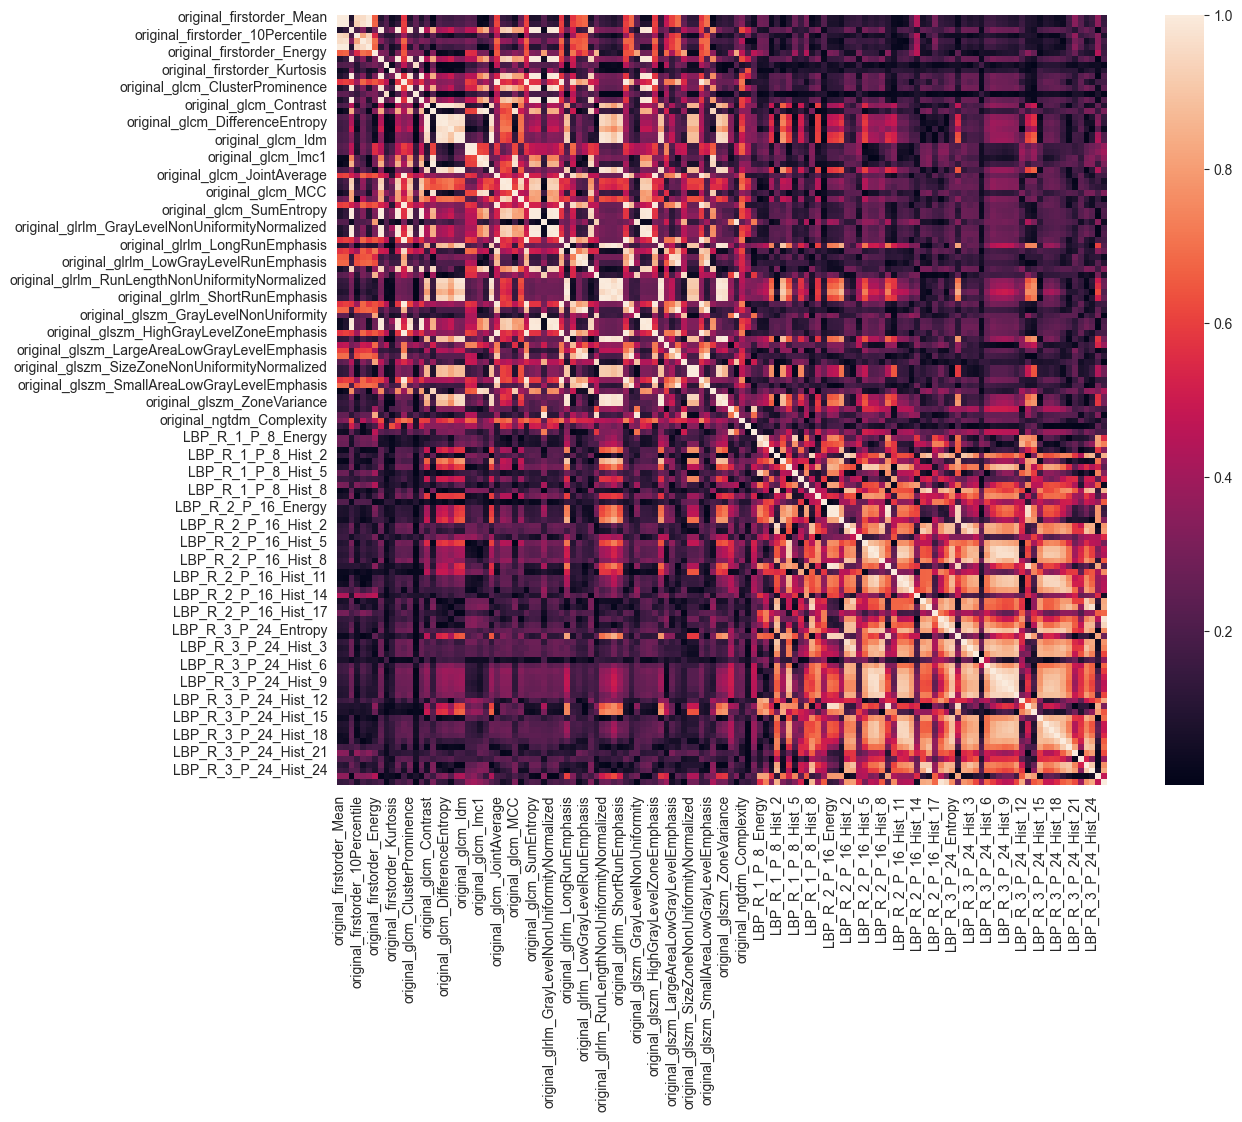

In [103]:
plt.figure(figsize=(15, 10))
plot_heat_map(features_ant)

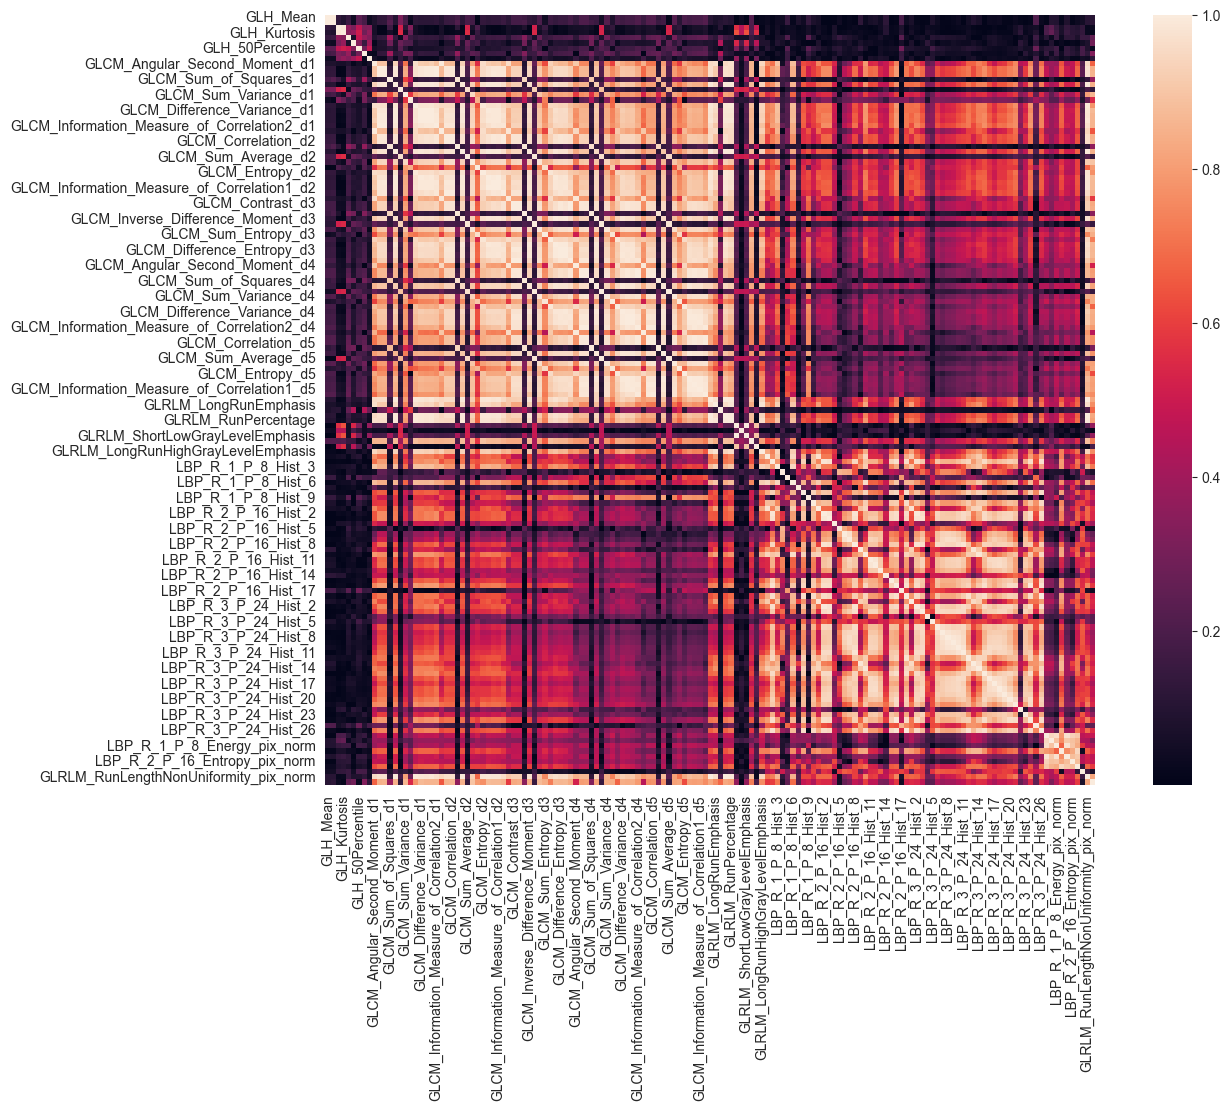

In [104]:
plt.figure(figsize=(15, 10))
plot_heat_map(features_ant_3sigma7_norm)

## Posterior images

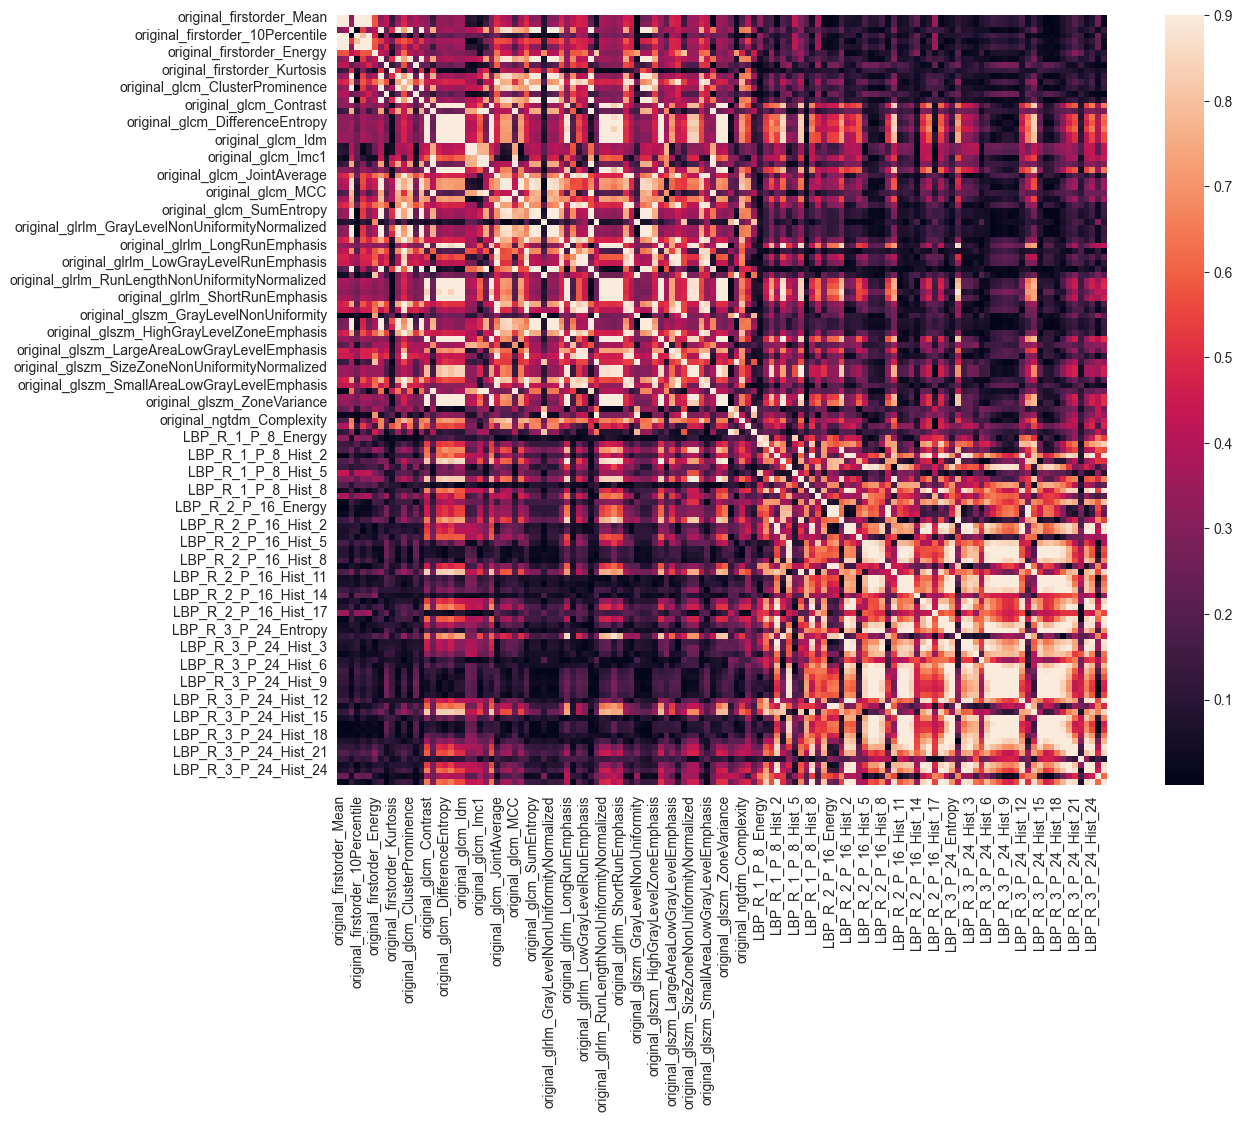

In [32]:
plt.figure(figsize=(15, 10))
plot_heat_map(features_post)